## **S&P500 Bullish Cycle**

/tmp/ipython-input-2515357576.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="1974-01-01", end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


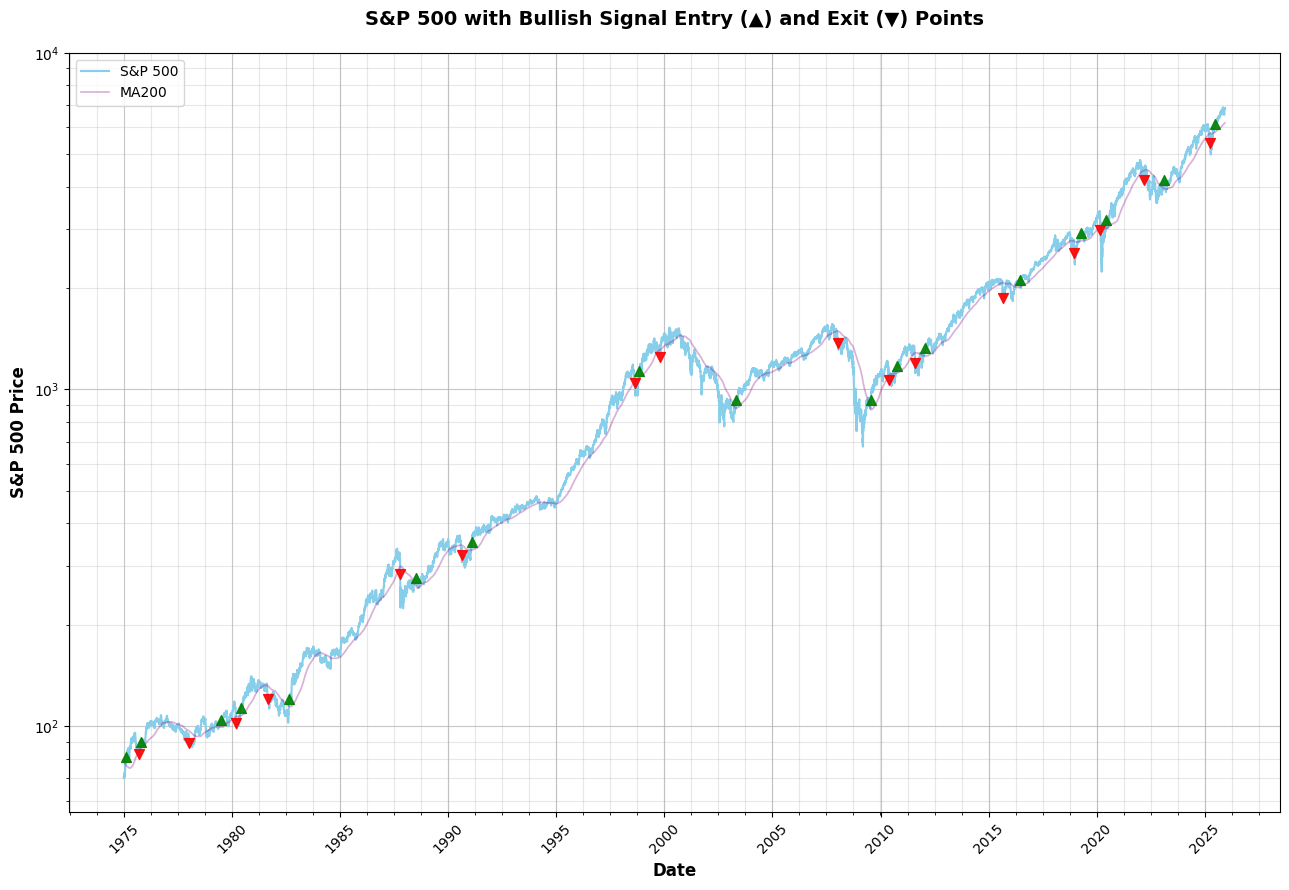


Signal Conditions
Entry Signal:
  1. Market down >= 12% from 26-week high (half-year)
  2. Current price is BELOW the 200-day Moving Average
  3. Recovery confirmation: current price breaks above MA200 by +5%

Exit Signal:
  1. Market drops >= 12% from 26-week high again
  2. Current price is BELOW the 200-day Moving Average

BULLISH SIGNAL RESULTS (1975-Present)
| Signal Date   |   Signal Price |   Peak at Signal | Exit Date         |   Exit Price |   Return (%) |   Period (months) |
|:--------------|---------------:|-----------------:|:------------------|-------------:|-------------:|------------------:|
| 1975-02-13    |          81.01 |            81.01 | 1975-09-15        |        82.88 |         2.31 |              7.13 |
| 1975-10-13    |          89.46 |            95.61 | 1978-01-16        |        89.43 |        -0.03 |             27.53 |
| 1979-07-09    |         104.47 |           104.47 | 1980-03-17        |       102.26 |        -2.12 |              8.4  |
| 1980-06-06 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ticker = "^SPX"
df = yf.download(ticker, start="1974-01-01", end=datetime.now().strftime('%Y-%m-%d'))

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

data = pd.DataFrame(index=df.index)
data['Close'] = df['Close']

# half_year high (approx. 126 trading days)
data['26w_High'] = data['Close'].rolling(window=125).max()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['Drawdown_Pct'] = ((data['Close'] - data['26w_High']) / data['26w_High']) * 100

research_start = pd.Timestamp('1975-01-01')
data_research = data[data.index >= research_start].copy()

signals = []
in_position = False        # whether currently holding a position
signal_date = None         # date when position was entered
signal_price = None        # price when entered
signal_peak = None         # half_year high at entry
in_drawdown = False        # whether the market is currently in a deep drawdown

for i in range(len(data_research)):
    current_date = data_research.index[i]
    current_price = data_research['Close'].iloc[i]
    current_drawdown = data_research['Drawdown_Pct'].iloc[i]
    current_ma200 = data_research['MA200'].iloc[i]
    current_26w_high = data_research['26w_High'].iloc[i]

    # skip days before the MA200 is established
    if pd.isna(current_ma200):
        continue

    # --- Entry Logic ---
    if not in_position:
        if current_drawdown <= -12 and current_price < current_ma200:
            in_drawdown = True

        # confirm recovery from drawdown --> price breaks above MA200 by {threshold}%
        if in_drawdown and current_price >= current_ma200 * 1.05:
            in_position = True
            signal_date = current_date
            signal_price = current_price
            signal_peak = current_26w_high
            in_drawdown = False

    # --- Exit Logic ---
    else:
        # exit when the market drops >12% again and falls below MA200
        if current_drawdown <= -12 and current_price < current_ma200:
            exit_date = current_date
            exit_price = current_price

            return_pct = ((exit_price - signal_price) / signal_price) * 100
            period_days = (exit_date - signal_date).days
            period_months = period_days / 30

            signals.append({
                'Signal Date': signal_date,
                'Signal Price': signal_price,
                'Peak at Signal': signal_peak,
                'Exit Date': exit_date,
                'Exit Price': exit_price,
                'Return (%)': return_pct,
                'Period (months)': period_months
            })

            in_position = False
            in_drawdown = False

# handle open position (if still holding at the end)
if in_position:
    exit_date = data_research.index[-1]
    exit_price = data_research['Close'].iloc[-1]
    return_pct = ((exit_price - signal_price) / signal_price) * 100
    period_days = (exit_date - signal_date).days
    period_months = period_days / 30

    signals.append({
        'Signal Date': signal_date,
        'Signal Price': signal_price,
        'Peak at Signal': signal_peak,
        'Exit Date': exit_date,
        'Exit Price': exit_price,
        'Return (%)': return_pct,
        'Period (months)': period_months,
        'Open': True
    })

fig, ax = plt.subplots(figsize=(13, 9))
ax.set_yscale('log')                      # log the price scale
ax.grid(which='major', alpha=0.7)
ax.grid(which='minor', alpha=0.3)
ax.minorticks_on()

ax.plot(data_research.index, data_research['Close'], label='S&P 500', linewidth=1.5, color='skyblue', alpha=1.0)
ax.plot(data_research.index, data_research['MA200'], label='MA200', linewidth=1.25, color='purple', alpha=0.3)
ax.set_ylim(top=10000)                    # set the y-axis limit

# mark entry (▲) and exit (▼) signals on the chart
if signals:
    for signal in signals:
        ax.scatter(signal['Signal Date'], signal['Signal Price'],
                   color='green', s=50, marker='^', zorder=5, alpha=0.9)
        is_open = signal.get('Open', False)
        if not is_open:
            ax.scatter(signal['Exit Date'], signal['Exit Price'],
                       color='red', s=50, marker='v', zorder=5, alpha=0.9)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('S&P 500 Price', fontsize=12, fontweight='bold')
ax.set_title('S&P 500 with Bullish Signal Entry (▲) and Exit (▼) Points',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.7)
ax.legend(loc='upper left', fontsize=10)

ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n" + "="*30)
print("Signal Conditions")
print("="*30)
print("Entry Signal:")
print("  1. Market down >= 12% from 26-week high (half-year)")
print("  2. Current price is BELOW the 200-day Moving Average")
print("  3. Recovery confirmation: current price breaks above MA200 by +5%")
print("\nExit Signal:")
print("  1. Market drops >= 12% from 26-week high again")
print("  2. Current price is BELOW the 200-day Moving Average")

if signals:
    df_signals = pd.DataFrame(signals)

    df_display = df_signals.copy()
    df_display['Signal Date'] = df_display['Signal Date'].dt.strftime('%Y-%m-%d')
    df_display['Exit Date'] = df_display['Exit Date'].dt.strftime('%Y-%m-%d')

    if 'Open' in df_display.columns:
        df_display.loc[df_display['Open'] == True, 'Exit Date'] = df_display.loc[df_display['Open'] == True, 'Exit Date'] + ' (Open)'
        df_display = df_display.drop('Open', axis=1)

    print("\n" + "="*30)
    print("BULLISH SIGNAL RESULTS (1975-Present)")
    print("="*30)

    table_data = []
    for _, row in df_display.iterrows():
        return_val = row['Return (%)']
        if return_val < 0:
            return_str = f"\033[1;31m{return_val:.2f}\033[0m"
        else:
            return_str = f"{return_val:.2f}"

        table_data.append([
            row['Signal Date'],
            f"{row['Signal Price']:.2f}",
            f"{row['Peak at Signal']:.2f}",
            row['Exit Date'],
            f"{row['Exit Price']:.2f}",
            return_str,
            f"{row['Period (months)']:.2f}"
        ])

    headers = ['Signal Date', 'Signal Price', 'Peak at Signal', 'Exit Date', 'Exit Price', 'Return (%)', 'Period (months)']
    print(tabulate(table_data, headers=headers, tablefmt='pipe'))

    print("\n" + "="*30)
    print("EVALUATION METRICS")
    print("="*30)

    returns = df_signals['Return (%)'].values
    periods = df_signals['Period (months)'].values

    stats = {
        'Metric': [
            'Mean Return (%)', 'Median Return (%)',
            'Mean Period (months)', 'Median Period (months)',
            'Max Period (months)', 'Min Period (months)',
            'Total Signals', 'Winning Signals', 'Win Rate (%)'
        ],
        'Value': [
            f"{np.mean(returns):.2f}",
            f"{np.median(returns):.2f}",
            f"{np.mean(periods):.2f}",
            f"{np.median(periods):.2f}",
            f"{np.max(periods):.2f}",
            f"{np.min(periods):.2f}",
            f"{len(signals)}",
            f"{sum(returns > 0)}",
            f"{(sum(returns > 0) / len(signals) * 100):.2f}"
        ]
    }

    df_stats = pd.DataFrame(stats)
    print(tabulate(df_stats, headers='keys', tablefmt='pipe', showindex=False))

else:
    print("\nNo signals found.")

print("\n" + "="*0)


Basically, this is a **quantitative indicator** that tracks **signals for S&P 500 bull market cycles**.

In the **50 years** since 1975, **a total of 17 signals** have occurred; **15 were accurate**, with the two false calls occurring in 1975 and 1979 (in other words, since 1980, the signal achieved a 100% accuracy!).

The **average return** for these 17 bull market cycle signals is **33.2%**, with an **average cycle length of 27.4 months** (2+ years period), a median of 21.3 months (nearly 2 years), a **maximum duration of 92 months** (almost 8 years), and a **shortest duration of 7 months** excluding the current ongoing cycle, which is 5.3 months so far (which means the ongoing bull cycle is still at young stage).

This 50-year history is very sufficient and robust data, as it essentially **covers the period since the 1973 collapse of the Bretton Woods system** up to the present day.

Major economic, financial, and geopolitical crises that occurred over this period include the:
- Crude Oil Crisis (1973)
- Great Stagflation (1970s)
- Gulf War (1990–1991)
- Black Monday (1987)
- Asian Financial Crisis (1997-1998)
- Dotcom bubble (2000)
- 9/11 Terror Attacks (2001)
- Subprime Mortgage Crisis (2007–2009)
- US-China Trade War (2018)
- COVID-19 Pandemic (2020)
- 2022 Inflation-driven / Excessive QE Bear Market (2022)
- 2025 Retaliatory Tariffs (2025)


## **QT_MA200-Driven Sentiment Strategy (NASDAQ100)**

/tmp/ipython-input-2548390338.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_symbol, start=start, end=end, progress=False)


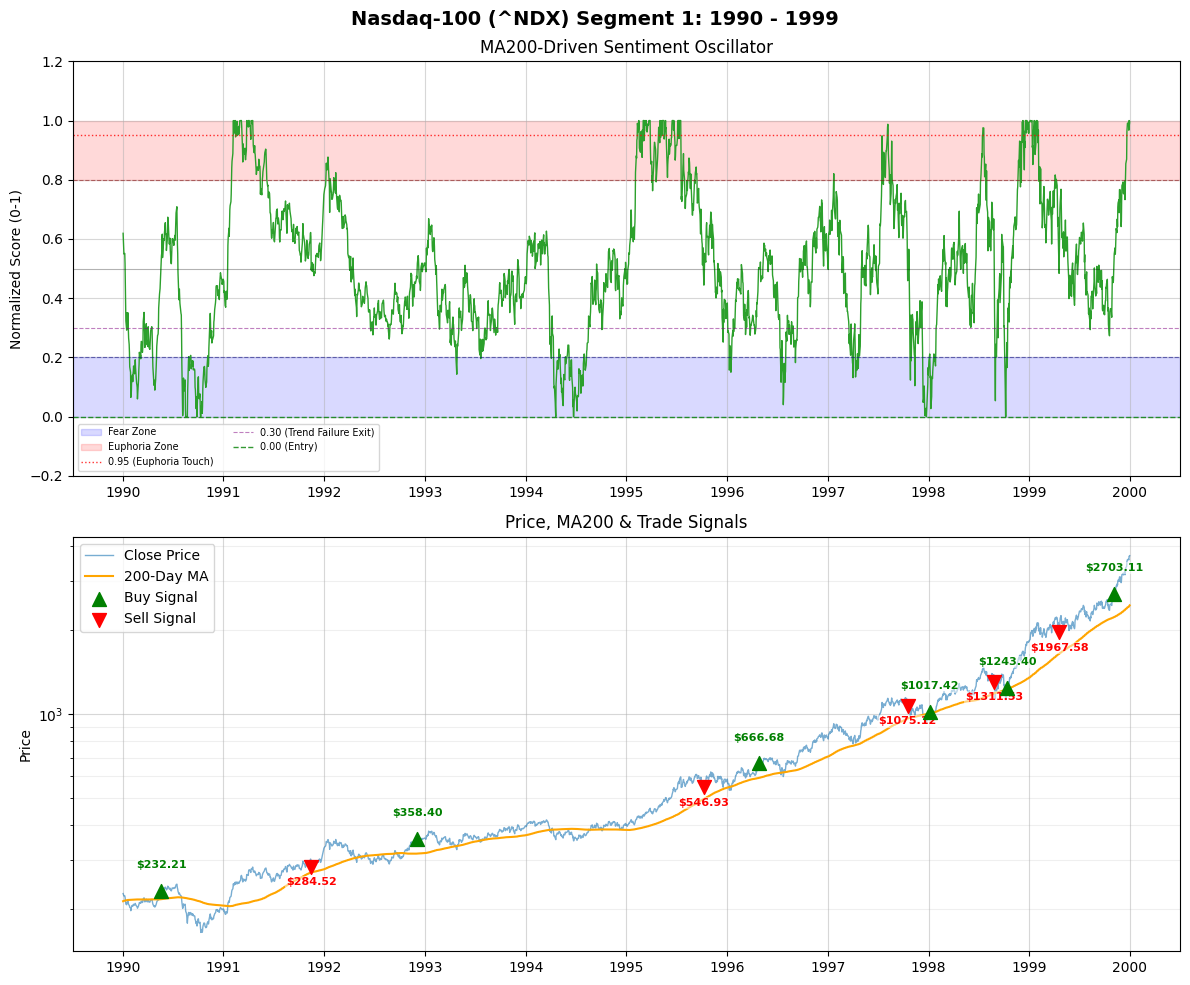

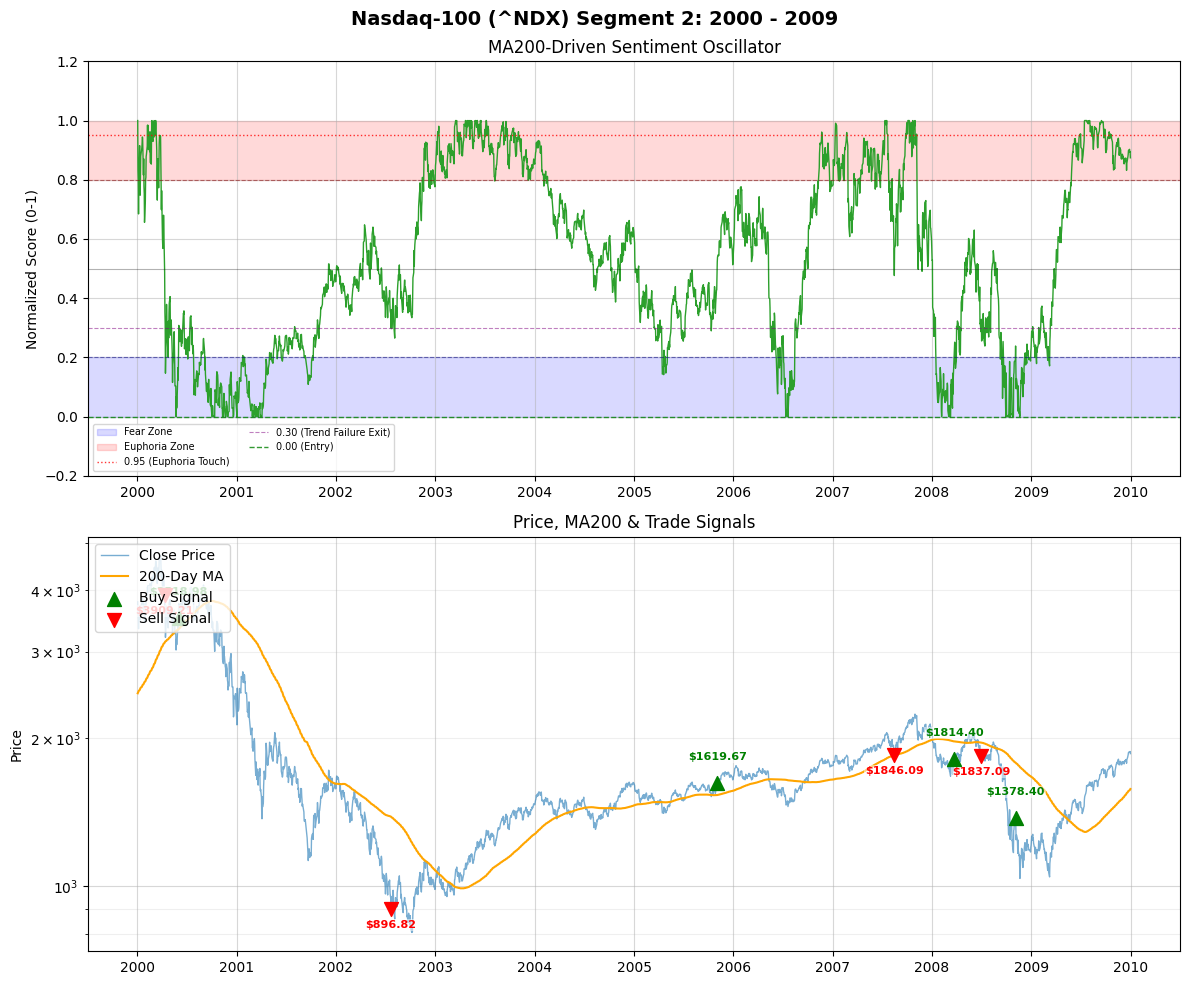

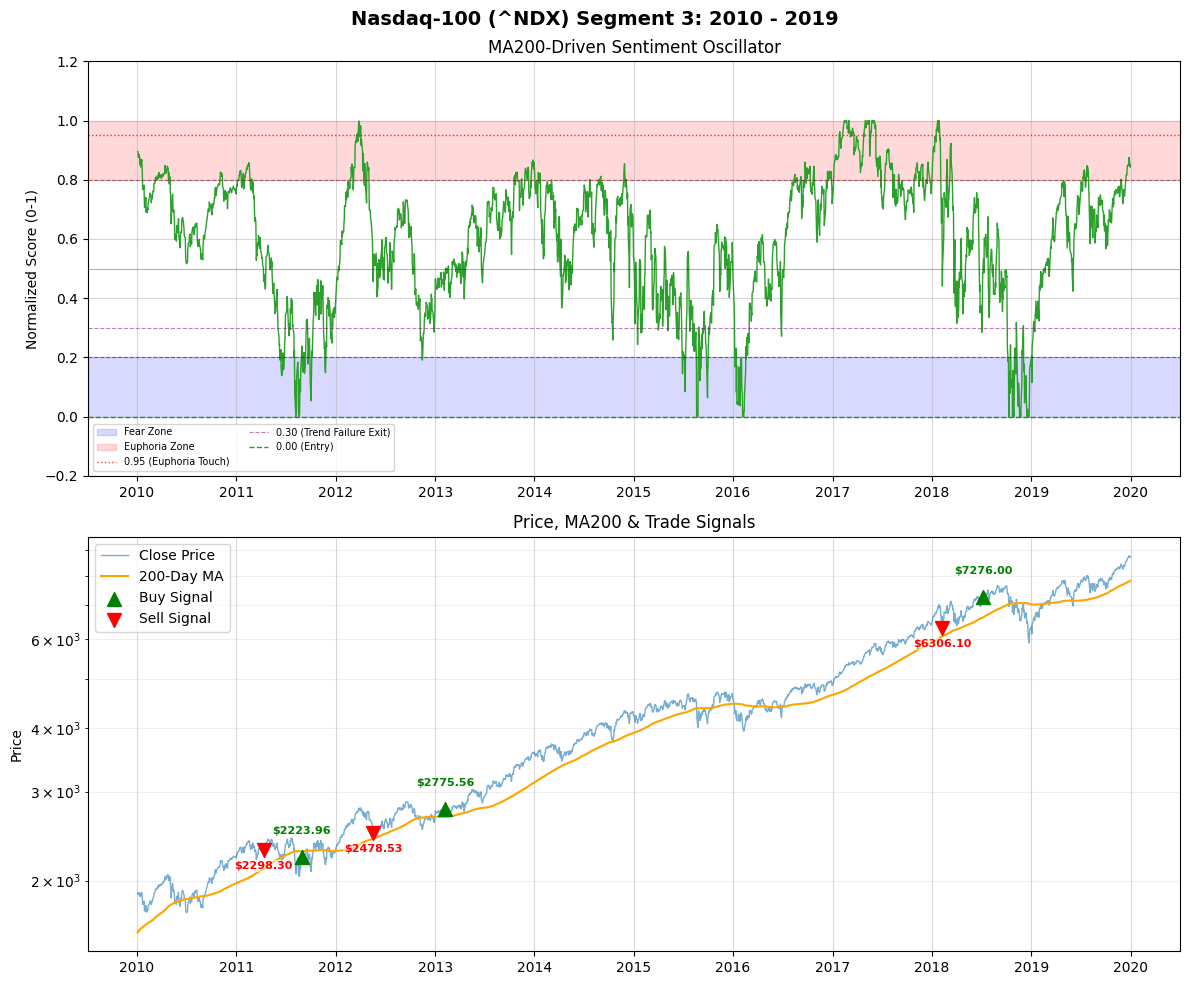

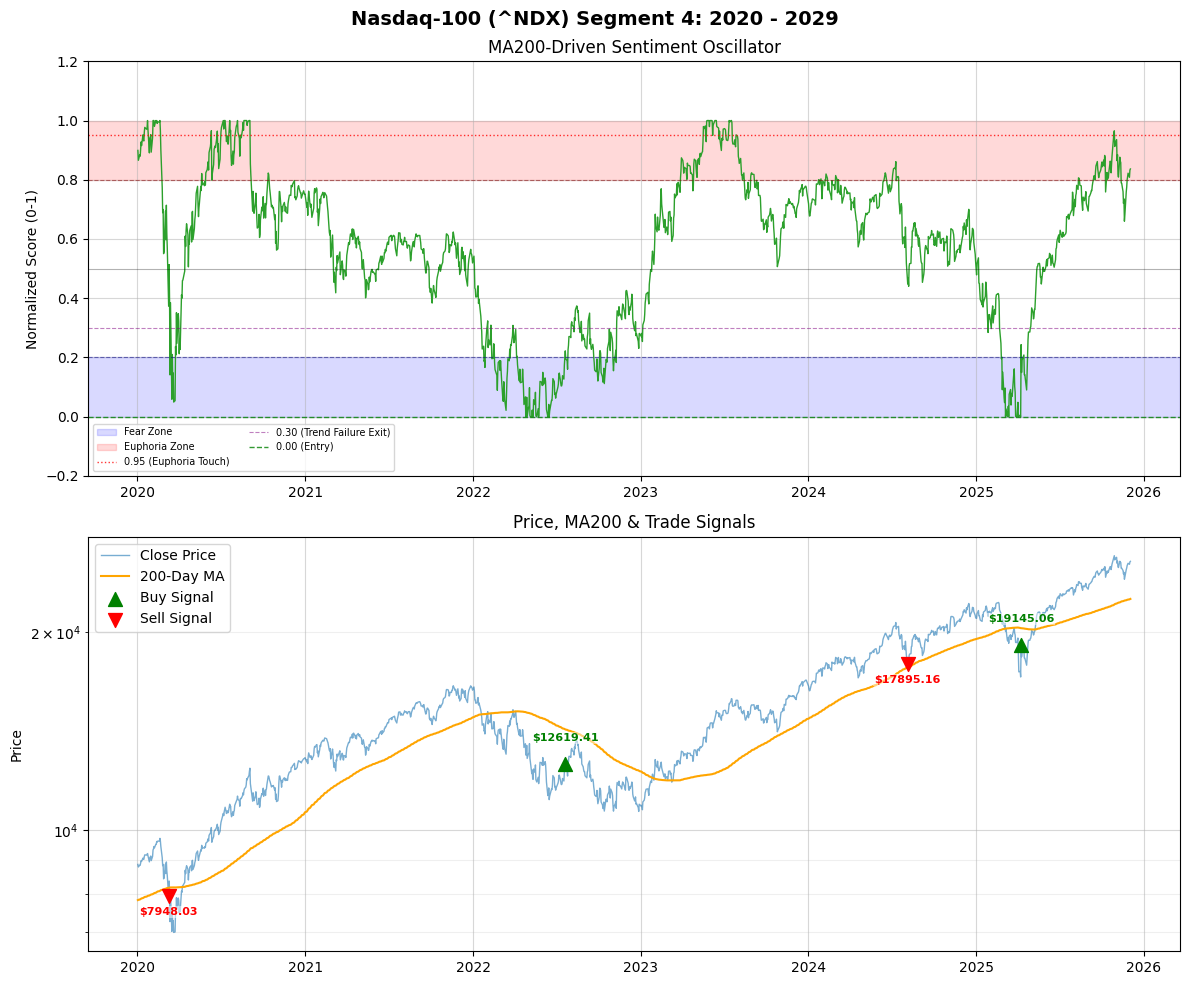



--- TRADING STRATEGY PERFORMANCE SUMMARY ---
Asset: **Nasdaq-100 (^NDX)**

| Entry Date   | Entry Price   | Entry Type   | Exit Date         | Exit Price   |   Holding Days | Run-Up (%)   | Return (%)   | Exit Reason   |
|:-------------|:--------------|:-------------|:------------------|:-------------|---------------:|:-------------|:-------------|:--------------|
| 1990-05-21   | $232.21       | Secondary    | 1991-11-15        | $284.52      |            543 | 30.41%       | 22.52%       | Euphoria Exit |
| 1992-12-04   | $358.40       | Secondary    | 1995-10-09        | $546.93      |           1039 | 70.13%       | 52.60%       | Euphoria Exit |
| 1996-04-25   | $666.68       | Secondary    | 1997-10-17        | $1075.12     |            540 | 72.23%       | 61.26%       | Euphoria Exit |
| 1998-01-05   | $1017.42      | Primary      | 1998-08-27        | $1311.53     |            234 | 44.08%       | 28.91%       | Euphoria Exit |
| 1998-10-12   | $1243.40      | Primary      |

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

start_date_download = "1985-01-01"
analysis_start_date = "1990-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")

# window for Min-Max normalization
norm_window = 500    # (approx 2 years)
SEGMENT_YEARS = 10

tickers = {
    "Nasdaq-100 (^NDX)": "^NDX"
}

all_trades = []

def fetch_and_process_data(ticker_symbol, start, end):
    df = yf.download(ticker_symbol, start=start, end=end, progress=False)

    if df.empty:
        print(f"No data found for {ticker_symbol}")
        return None

    if isinstance(df.columns, pd.MultiIndex):
        df = df.xs(ticker_symbol, level=1, axis=1)

    # calculate MA200 & raw deviation
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['Raw_Deviation'] = ((df['Close'] - df['MA200']) / df['MA200'])

    # apply rolling Min-Max normalization
    roll_min = df['Raw_Deviation'].rolling(window=norm_window).min()
    roll_max = df['Raw_Deviation'].rolling(window=norm_window).max()
    df['Norm_Sentiment'] = (df['Raw_Deviation'] - roll_min) / (roll_max - roll_min)

    # generate Buy/Sell Signals and track trades
    buy_signals = []
    sell_signals = []

    holding = False
    touched_95 = False
    touched_50 = False
    touched_00 = False
    touched_30_for_secondary_entry = False # new flag for secondary entry
    entry_date = None
    entry_price = None
    entry_type = None # to store 'Primary' or 'Secondary'
    trade_segment_data = []
    days_since_last_entry = 0 # to track days since last entry

    for i in range(len(df)):
        date = df.index[i]
        close_price = df['Close'].iloc[i]
        sentiment = df['Norm_Sentiment'].iloc[i]

        if pd.isna(sentiment) or pd.isna(close_price):
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)
            if not holding:
                days_since_last_entry += 1
            continue

        if not holding:
            days_since_last_entry += 1 # Increment if not holding

            if sentiment == 0.00:
                touched_00 = True
                touched_30_for_secondary_entry = False # reset secondary flag if primary touched
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
            elif touched_00 and sentiment > 0.20: # Primary Entry: touched 0.00 and now sentiment > 0.20
                buy_signals.append(close_price)
                sell_signals.append(np.nan)
                holding = True
                touched_95 = False
                touched_50 = False
                entry_date = date
                entry_price = close_price
                entry_type = 'Primary'
                trade_segment_data = [close_price]
                touched_00 = False # reset touched_00 after primary entry
                days_since_last_entry = 0 # reset on entry
            elif not touched_00 and sentiment <= 0.30: # Secondary Entry precursor: touched 0.30 (without touching 0.00)
                touched_30_for_secondary_entry = True
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
            elif not touched_00 and touched_30_for_secondary_entry and sentiment >= 0.50 and days_since_last_entry > 100: # Secondary Entry: no opening trade, touched 0.30 and rebounded to 0.50, and > 100 days since last entry
                buy_signals.append(close_price)
                sell_signals.append(np.nan)
                holding = True
                touched_95 = False
                touched_50 = False
                entry_date = date
                entry_price = close_price
                entry_type = 'Secondary'
                trade_segment_data = [close_price]
                touched_30_for_secondary_entry = False # reset secondary flag after entry
                days_since_last_entry = 0 # reset on entry
            else:
                # if sentiment goes above 0.20/0.50 without having touched 0.00/0.30, reset flags
                if sentiment > 0.50:
                    touched_00 = False
                    touched_30_for_secondary_entry = False
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)

        else: # check if currently holding a position
            buy_signals.append(np.nan)
            days_since_last_entry = 0 # reset if holding

            if sentiment >= 0.95:
                touched_95 = True
            if sentiment >= 0.50:
                touched_50 = True

            trade_segment_data.append(close_price)

            # EXIT CONDITIONS
            cond_euphoria = touched_95 and (sentiment < 0.50)
            cond_failure = touched_50 and (sentiment < 0.30)

            exit_now = False
            exit_reason = ""

            if entry_type == 'Secondary':
                if cond_euphoria:
                    exit_now = True
                    exit_reason = "Euphoria Exit"
            else:
                if cond_euphoria:
                    exit_now = True
                    exit_reason = "Euphoria Exit"
                elif cond_failure:
                    exit_now = True
                    exit_reason = "Trend Failure"

            if exit_now:
                sell_signals.append(close_price)
                holding = False

                exit_date = date
                exit_price = close_price

                max_price = max(trade_segment_data)
                run_up_percent = ((max_price - entry_price) / entry_price) * 100 if entry_price else 0
                final_return_percent = ((exit_price - entry_price) / entry_price) * 100 if entry_price else 0
                holding_period_days = (exit_date - entry_date).days if entry_date else 0

                all_trades.append({
                    'Asset': yf.ticker.Ticker(ticker_symbol).info.get('shortName', ticker_symbol),
                    'Entry Date': entry_date.strftime('%Y-%m-%d'),
                    'Entry Price': entry_price,
                    'Entry Type': entry_type,
                    'Exit Date': exit_date.strftime('%Y-%m-%d'),
                    'Exit Price': exit_price,
                    'Run-Up (%)': run_up_percent,
                    'Return (%)': final_return_percent,
                    'Holding Days': holding_period_days,
                    'Exit Reason': exit_reason
                })

                entry_date = None
                entry_price = None
                entry_type = None
                trade_segment_data = []
                touched_00 = False # reset touched_00 on exit as well
                touched_30_for_secondary_entry = False # reset secondary flag on exit as well

            else:
                sell_signals.append(np.nan)

    # handle open position (if still holding at the end)
    if holding and entry_date is not None:
        last_date = df.index[-1]
        last_price = df['Close'].iloc[-1]

        max_price = max(trade_segment_data)
        run_up_percent = ((max_price - entry_price) / entry_price) * 100 if entry_price else 0
        final_return_percent = ((last_price - entry_price) / entry_price) * 100 if entry_price else 0
        holding_period_days = (last_date - entry_date).days if entry_date else 0

        all_trades.append({
            'Asset': yf.ticker.Ticker(ticker_symbol).info.get('shortName', ticker_symbol),
            'Entry Date': entry_date.strftime('%Y-%m-%d'),
            'Entry Price': entry_price,
            'Entry Type': entry_type,
            'Exit Date': last_date.strftime('%Y-%m-%d') + ' (Open)',
            'Exit Price': last_price,
            'Run-Up (%)': run_up_percent,
            'Return (%)': final_return_percent,
            'Holding Days': holding_period_days,
            'Exit Reason': 'Open Position'
        })


    df['Buy_Signal'] = buy_signals
    df['Sell_Signal'] = sell_signals

    df.dropna(subset=['MA200', 'Norm_Sentiment'], inplace=True)
    return df

def plot_segmented_analysis(df, asset_name, start_filter, segment_length_years):
    df_analysis = df[df.index >= start_filter]

    if df_analysis.empty:
        print(f"No data available for {asset_name}.")
        return

    start_year = df_analysis.index.min().year
    end_year = df_analysis.index.max().year
    current_year = start_year

    plot_num = 1

    while current_year <= end_year:
        segment_start = f"{current_year}-01-01"
        segment_end = f"{current_year + segment_length_years - 1}-12-31"

        df_segment = df_analysis.loc[segment_start:segment_end]

        if df_segment.empty or len(df_segment) < 2:
            current_year += segment_length_years
            continue

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        plt.suptitle(
            f"{asset_name} Segment {plot_num}: {segment_start.split('-')[0]} - {segment_end.split('-')[0]}",
            fontsize=14, fontweight="bold"
        )

        # --- LEFT PANEL: Normalized Sentiment (0 to 1) ---
        ax1.plot(df_segment.index, df_segment['Norm_Sentiment'], color='#2ca02c', linewidth=1)

        ax1.axhspan(0.0, 0.20, color='blue', alpha=0.15, label="Fear Zone")
        ax1.axhspan(0.80, 1.0, color='red', alpha=0.15, label="Euphoria Zone")

        ax1.axhline(0.95, color='red', linestyle=':', linewidth=1, alpha=0.8, label="0.95 (Euphoria Touch)")
        ax1.axhline(0.80, color='maroon', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.axhline(0.50, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
        ax1.axhline(0.30, color='purple', linestyle='--', linewidth=0.8, alpha=0.5, label="0.30 (Trend Failure Exit)")
        ax1.axhline(0.20, color='navy', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.axhline(0.00, color='green', linestyle='--', linewidth=1, alpha=0.8, label="0.00 (Entry)")

        ax1.set_title(f"MA200-Driven Sentiment Oscillator")
        ax1.set_ylabel("Normalized Score (0-1)")
        ax1.set_ylim(-0.2, 1.2)
        ax1.legend(loc='lower left', fontsize='x-small', ncol=2)
        ax1.grid(True, which='major', alpha=0.5)
        ax1.grid(True, which='minor', alpha=0.2)

        # --- RIGHT PANEL: Price + Signals with Labels ---
        ax2.plot(df_segment.index, df_segment['Close'], label='Close Price', color='#1f77b4', alpha=0.6, linewidth=1)
        ax2.plot(df_segment.index, df_segment['MA200'], label='200-Day MA', color='orange', linewidth=1.5)

        buy_points = df_segment[df_segment['Buy_Signal'].notna()]
        sell_points = df_segment[df_segment['Sell_Signal'].notna()]

        # buy signals (Green Triangle Up)
        ax2.scatter(buy_points.index, buy_points['Buy_Signal'],
                     marker='^', color='green', s=100, zorder=5, label='Buy Signal')

        # sell signals (Red Triangle Down)
        ax2.scatter(sell_points.index, sell_points['Sell_Signal'],
                     marker='v', color='red', s=100, zorder=5, label='Sell Signal')

        for index, row in buy_points.iterrows():
            price = row['Buy_Signal']
            ax2.annotate(f"${price:.2f}", (index, price),
                         textcoords="offset points",
                         xytext=(0, 15),
                         ha='center', va='bottom', fontsize=8, fontweight='bold', color='green',
                         bbox=dict(boxstyle="square,pad=0.1", fc="white", alpha=0.5, ec='none'))

        for index, row in sell_points.iterrows():
            price = row['Sell_Signal']
            ax2.annotate(f"${price:.2f}", (index, price),
                         textcoords="offset points",
                         xytext=(0, -15),
                         ha='center', va='bottom', fontsize=8, fontweight='bold', color='red',
                         bbox=dict(boxstyle="square,pad=0.1", fc="white", alpha=0.5, ec='none'))


        ax2.set_title("Price, MA200 & Trade Signals")
        ax2.set_ylabel("Price")
        ax2.legend(loc='upper left')
        ax2.grid(True, which='major', alpha=0.5)
        ax2.grid(True, which='minor', alpha=0.2)

        ax2.set_yscale('log')

        plt.tight_layout()
        plt.show()

        current_year += segment_length_years
        plot_num += 1

for name, symbol in tickers.items():
    all_trades = []
    data = fetch_and_process_data(symbol, start_date_download, end_date)

    if data is not None:
        plot_segmented_analysis(data, name, analysis_start_date, SEGMENT_YEARS)

        print("\n" * 2 + "--- TRADING STRATEGY PERFORMANCE SUMMARY ---")

        if all_trades:
            trade_df = pd.DataFrame(all_trades)

            trade_df['Entry Price'] = trade_df['Entry Price'].apply(lambda x: f"${x:.2f}")
            trade_df['Exit Price'] = trade_df['Exit Price'].apply(lambda x: f"${x:.2f}")
            trade_df['Run-Up (%)'] = trade_df['Run-Up (%)'].apply(lambda x: f"{x:.2f}%")
            trade_df['Return (%)'] = trade_df['Return (%)'].apply(lambda x: f"{x:.2f}%")

            trade_df = trade_df[[
                'Entry Date', 'Entry Price', 'Entry Type',
                'Exit Date', 'Exit Price',
                'Holding Days', 'Run-Up (%)', 'Return (%)', 'Exit Reason'
            ]]

            print(f"Asset: **{name}**\n")
            print(trade_df.to_markdown(index=False))

            print("\n--- Summary Statistics ---")
            closed_trades = [t for t in all_trades if t['Exit Reason'] != 'Open Position']
            if closed_trades:
                closed_returns = [t['Return (%)'] for t in closed_trades]

                numeric_returns = closed_returns

                wins = len([r for r in numeric_returns if r > 0])
                losses = len([r for r in numeric_returns if r < 0])
                total_closed_trades = wins + losses + len([r for r in numeric_returns if r == 0])

                avg_return = np.mean(numeric_returns)
                win_rate = (wins / total_closed_trades) * 100 if total_closed_trades > 0 else 0

                print(f"- Total Closed Trades: {total_closed_trades}")
                print(f"- Winning Trades: {wins}")
                print(f"- Losing Trades: {losses}")
                print(f"- Win Rate: {win_rate:.2f}%")
                print(f"- Average Return (per closed trade): {avg_return:.2f}%")
            else:
                print("No closed trades to calculate.")
        else:
            print("No trades generated.")


**Refinement needed:** Should figure out ways to avoid the next -74.51% lose trade though it is quite difficult to avoid this level of bubble burst.

**Same strategy but with Stop Loss & Cooling Period**

/tmp/ipython-input-4230984337.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_symbol, start=start, end=end, progress=False)


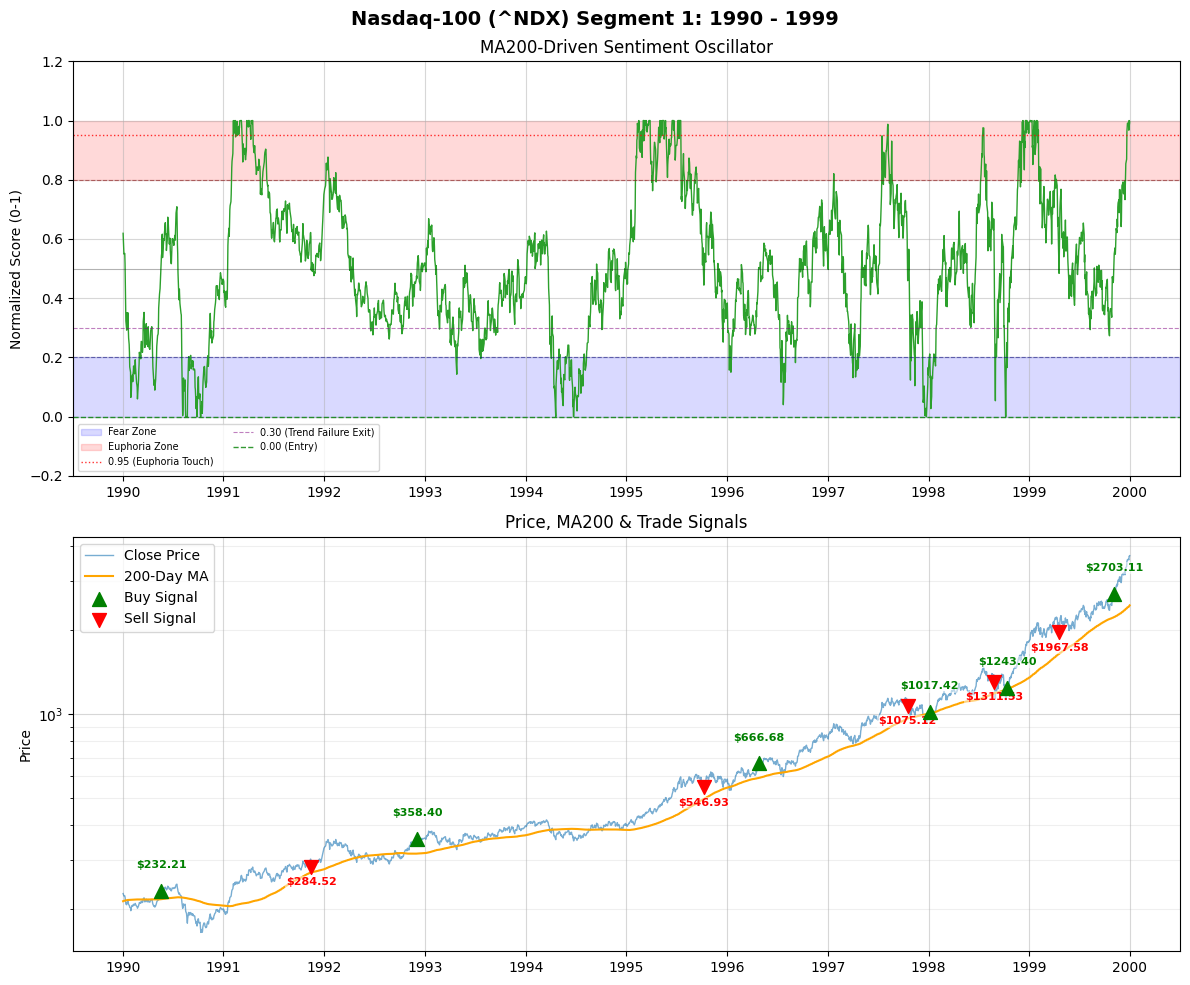

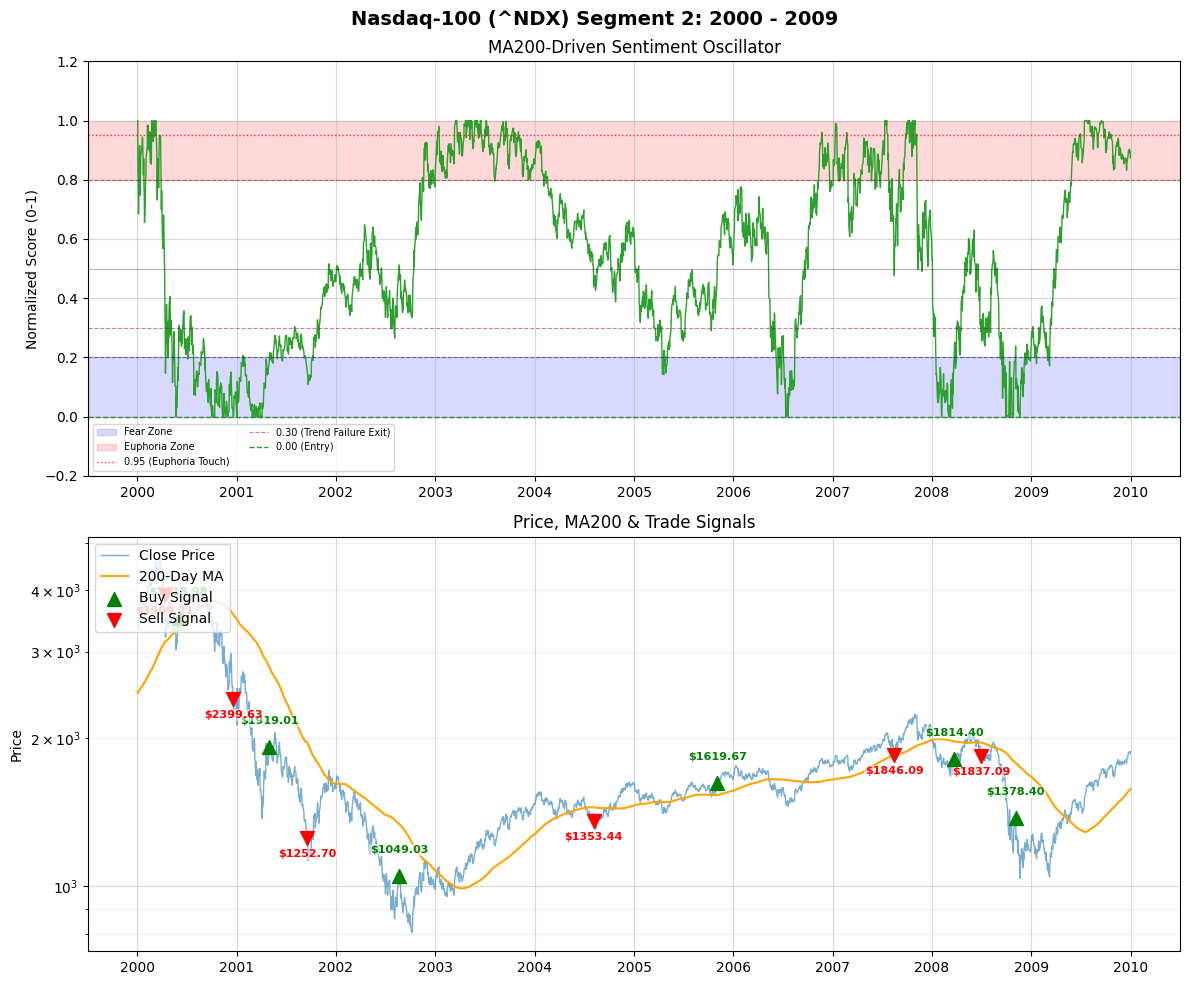

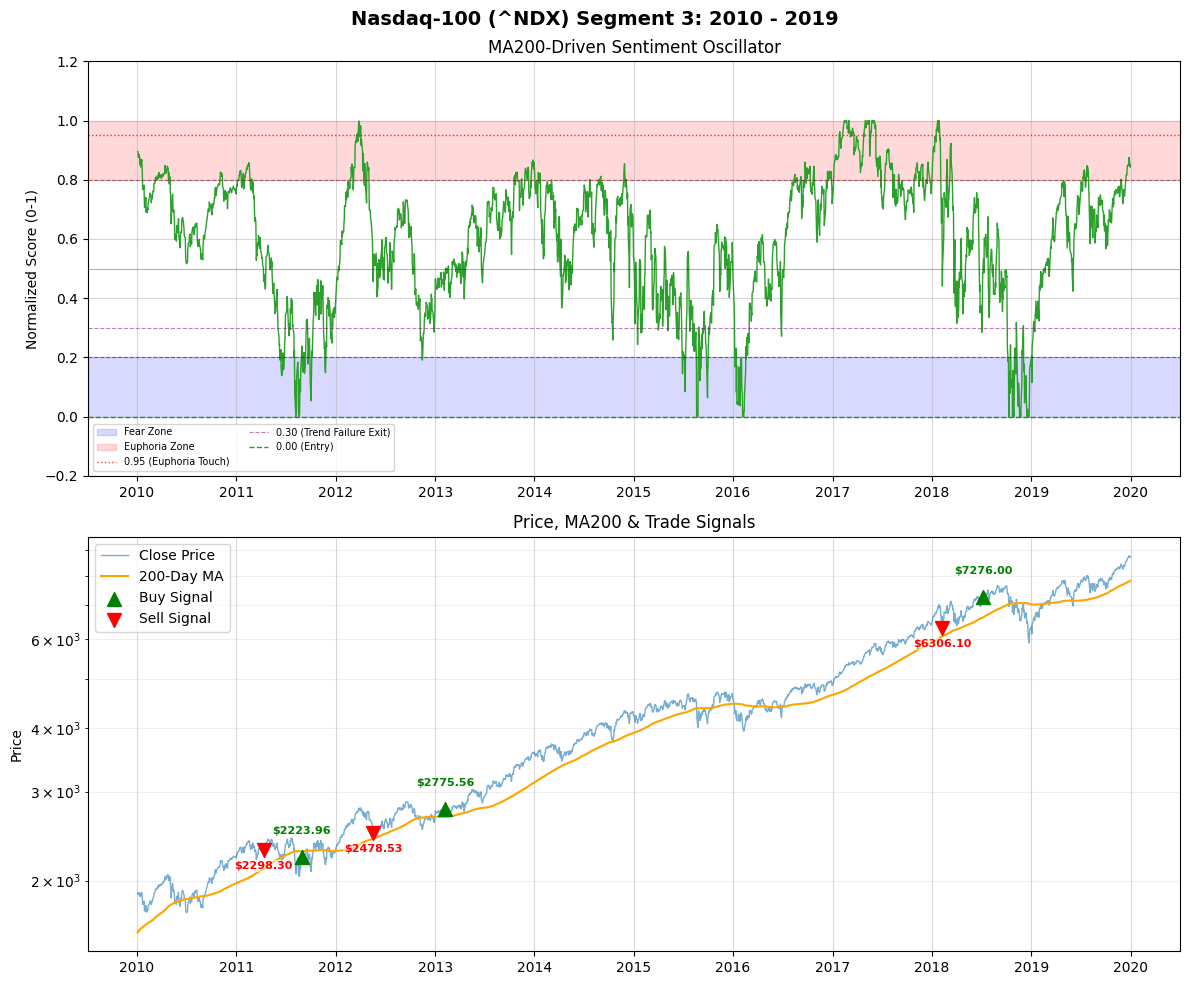

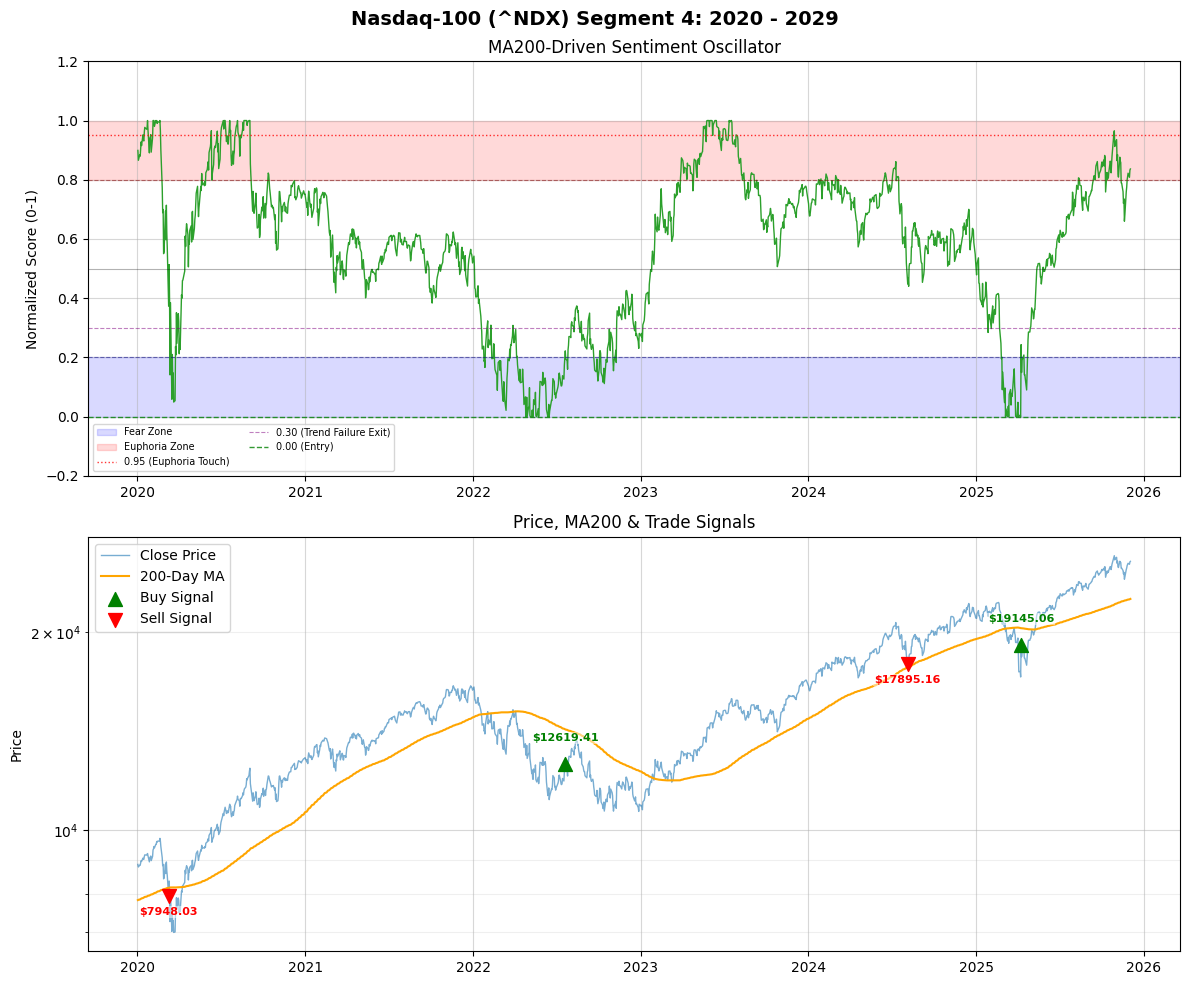



--- TRADING STRATEGY PERFORMANCE SUMMARY ---
Asset: **Nasdaq-100 (^NDX)**

| Entry Date   | Entry Price   | Entry Type   | Exit Date         | Exit Price   |   Holding Days | Run-Up (%)   | Return (%)   | Exit Reason   |
|:-------------|:--------------|:-------------|:------------------|:-------------|---------------:|:-------------|:-------------|:--------------|
| 1990-05-21   | $232.21       | Secondary    | 1991-11-15        | $284.52      |            543 | 30.41%       | 22.52%       | Euphoria Exit |
| 1992-12-04   | $358.40       | Secondary    | 1995-10-09        | $546.93      |           1039 | 70.13%       | 52.60%       | Euphoria Exit |
| 1996-04-25   | $666.68       | Secondary    | 1997-10-17        | $1075.12     |            540 | 72.23%       | 61.26%       | Euphoria Exit |
| 1998-01-05   | $1017.42      | Primary      | 1998-08-27        | $1311.53     |            234 | 44.08%       | 28.91%       | Euphoria Exit |
| 1998-10-12   | $1243.40      | Primary      |

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

start_date_download = "1985-01-01"
analysis_start_date = "1990-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")

# window for Min-Max normalization
norm_window = 500    # (approx 2 years)
SEGMENT_YEARS = 10

tickers = {
    "Nasdaq-100 (^NDX)": "^NDX"
}

all_trades = []

def fetch_and_process_data(ticker_symbol, start, end):
    df = yf.download(ticker_symbol, start=start, end=end, progress=False)

    if df.empty:
        print(f"No data found for {ticker_symbol}")
        return None

    if isinstance(df.columns, pd.MultiIndex):
        df = df.xs(ticker_symbol, level=1, axis=1)

    # calculate MA200 & raw deviation
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['Raw_Deviation'] = ((df['Close'] - df['MA200']) / df['MA200'])

    # apply rolling Min-Max normalization
    roll_min = df['Raw_Deviation'].rolling(window=norm_window).min()
    roll_max = df['Raw_Deviation'].rolling(window=norm_window).max()
    df['Norm_Sentiment'] = (df['Raw_Deviation'] - roll_min) / (roll_max - roll_min)

    # generate Buy/Sell Signals and track trades
    buy_signals = []
    sell_signals = []

    holding = False
    touched_95 = False
    touched_50 = False
    touched_00 = False
    touched_30_for_secondary_entry = False # new flag for secondary entry
    entry_date = None
    entry_price = None
    entry_type = None # to store 'Primary' or 'Secondary'
    trade_segment_data = []
    days_since_last_entry = 0
    cool_down_days_remaining = 0

    for i in range(len(df)):
        date = df.index[i]
        close_price = df['Close'].iloc[i]
        sentiment = df['Norm_Sentiment'].iloc[i]

        if pd.isna(sentiment) or pd.isna(close_price):
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)
            if not holding:
                days_since_last_entry += 1
                if cool_down_days_remaining > 0:
                    cool_down_days_remaining -= 1
            continue

        if not holding:
            days_since_last_entry += 1
            if cool_down_days_remaining > 0:
                cool_down_days_remaining -= 1
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
                continue # skip entry logic if in cooling period

            if sentiment == 0.00:
                touched_00 = True
                touched_30_for_secondary_entry = False # reset secondary flag if primary touched
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
            elif touched_00 and sentiment > 0.20: # Primary Entry: touched 0.00 and now sentiment > 0.20
                buy_signals.append(close_price)
                sell_signals.append(np.nan)
                holding = True
                touched_95 = False
                touched_50 = False
                entry_date = date
                entry_price = close_price
                entry_type = 'Primary'
                trade_segment_data = [close_price]
                touched_00 = False # reset touched_00 after primary entry
                days_since_last_entry = 0 # reset on entry
            elif not touched_00 and sentiment <= 0.30: # Secondary Entry precursor: touched 0.30 (without touching 0.00)
                touched_30_for_secondary_entry = True
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
            elif not touched_00 and touched_30_for_secondary_entry and sentiment >= 0.50 and days_since_last_entry > 100: # Secondary Entry: no opening trade, touched 0.30 and rebounded to 0.50, and > 100 days since last entry
                buy_signals.append(close_price)
                sell_signals.append(np.nan)
                holding = True
                touched_95 = False
                touched_50 = False
                entry_date = date
                entry_price = close_price
                entry_type = 'Secondary'
                trade_segment_data = [close_price]
                touched_30_for_secondary_entry = False # reset secondary flag after entry
                days_since_last_entry = 0 # reset on entry
            else:
                # if sentiment goes above 0.20/0.50 without having touched 0.00/0.30, reset flags
                if sentiment > 0.50:
                    touched_00 = False
                    touched_30_for_secondary_entry = False
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)

        else: # check if currently holding a position
            buy_signals.append(np.nan)
            days_since_last_entry = 0 # reset if holding

            if sentiment >= 0.95:
                touched_95 = True
            if sentiment >= 0.50:
                touched_50 = True

            trade_segment_data.append(close_price)

            # check for stop loss
            current_return_percent = ((close_price - entry_price) / entry_price) * 100 if entry_price else 0
            cond_stop_loss = current_return_percent <= -30  # stop-loss level

            # EXIT CONDITIONS
            cond_euphoria = touched_95 and (sentiment < 0.50)
            cond_failure = touched_50 and (sentiment < 0.30)

            exit_now = False
            exit_reason = ""

            if cond_stop_loss: # stop loss has highest priority
                exit_now = True
                exit_reason = "Stop Loss"
            elif entry_type == 'Secondary':
                if cond_euphoria:
                    exit_now = True
                    exit_reason = "Euphoria Exit"
            else:
                if cond_euphoria:
                    exit_now = True
                    exit_reason = "Euphoria Exit"
                elif cond_failure:
                    exit_now = True
                    exit_reason = "Trend Failure"

            if exit_now:
                sell_signals.append(close_price)
                holding = False

                exit_date = date
                exit_price = close_price

                max_price = max(trade_segment_data)
                run_up_percent = ((max_price - entry_price) / entry_price) * 100 if entry_price else 0
                final_return_percent = ((exit_price - entry_price) / entry_price) * 100 if entry_price else 0
                holding_period_days = (exit_date - entry_date).days if entry_date else 0

                all_trades.append({
                    'Asset': yf.ticker.Ticker(ticker_symbol).info.get('shortName', ticker_symbol),
                    'Entry Date': entry_date.strftime('%Y-%m-%d'),
                    'Entry Price': entry_price,
                    'Entry Type': entry_type,
                    'Exit Date': exit_date.strftime('%Y-%m-%d'),
                    'Exit Price': exit_price,
                    'Run-Up (%)': run_up_percent,
                    'Return (%)': final_return_percent,
                    'Holding Days': holding_period_days,
                    'Exit Reason': exit_reason
                })

                entry_date = None
                entry_price = None
                entry_type = None
                trade_segment_data = []
                touched_00 = False # reset touched_00 on exit as well
                touched_30_for_secondary_entry = False  # reset secondary flag on exit as well
                if exit_reason == "Stop Loss":
                    cool_down_days_remaining = 42       # apply two months cooling period

            else:
                sell_signals.append(np.nan)

    # handle open position (if still holding at the end)
    if holding and entry_date is not None:
        last_date = df.index[-1]
        last_price = df['Close'].iloc[-1]

        max_price = max(trade_segment_data)
        run_up_percent = ((max_price - entry_price) / entry_price) * 100 if entry_price else 0
        final_return_percent = ((last_price - entry_price) / entry_price) * 100 if entry_price else 0
        holding_period_days = (last_date - entry_date).days if entry_date else 0

        all_trades.append({
            'Asset': yf.ticker.Ticker(ticker_symbol).info.get('shortName', ticker_symbol),
            'Entry Date': entry_date.strftime('%Y-%m-%d'),
            'Entry Price': entry_price,
            'Entry Type': entry_type,
            'Exit Date': last_date.strftime('%Y-%m-%d') + ' (Open)',
            'Exit Price': last_price,
            'Run-Up (%)': run_up_percent,
            'Return (%)': final_return_percent,
            'Holding Days': holding_period_days,
            'Exit Reason': 'Open Position'
        })


    df['Buy_Signal'] = buy_signals
    df['Sell_Signal'] = sell_signals

    df.dropna(subset=['MA200', 'Norm_Sentiment'], inplace=True)
    return df

def plot_segmented_analysis(df, asset_name, start_filter, segment_length_years):
    df_analysis = df[df.index >= start_filter]

    if df_analysis.empty:
        print(f"No data available for {asset_name}.")
        return

    start_year = df_analysis.index.min().year
    end_year = df_analysis.index.max().year
    current_year = start_year

    plot_num = 1

    while current_year <= end_year:
        segment_start = f"{current_year}-01-01"
        segment_end = f"{current_year + segment_length_years - 1}-12-31"

        df_segment = df_analysis.loc[segment_start:segment_end]

        if df_segment.empty or len(df_segment) < 2:
            current_year += segment_length_years
            continue

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        plt.suptitle(
            f"{asset_name} Segment {plot_num}: {segment_start.split('-')[0]} - {segment_end.split('-')[0]}",
            fontsize=14, fontweight="bold"
        )

        # --- LEFT PANEL: Normalized Sentiment (0 to 1) ---
        ax1.plot(df_segment.index, df_segment['Norm_Sentiment'], color='#2ca02c', linewidth=1)

        ax1.axhspan(0.0, 0.20, color='blue', alpha=0.15, label="Fear Zone")
        ax1.axhspan(0.80, 1.0, color='red', alpha=0.15, label="Euphoria Zone")

        ax1.axhline(0.95, color='red', linestyle=':', linewidth=1, alpha=0.8, label="0.95 (Euphoria Touch)")
        ax1.axhline(0.80, color='maroon', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.axhline(0.50, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
        ax1.axhline(0.30, color='purple', linestyle='--', linewidth=0.8, alpha=0.5, label="0.30 (Trend Failure Exit)") # Added 0.30 line
        ax1.axhline(0.20, color='navy', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.axhline(0.00, color='green', linestyle='--', linewidth=1, alpha=0.8, label="0.00 (Entry)")

        ax1.set_title(f"MA200-Driven Sentiment Oscillator")
        ax1.set_ylabel("Normalized Score (0-1)")
        ax1.set_ylim(-0.2, 1.2)
        ax1.legend(loc='lower left', fontsize='x-small', ncol=2)
        ax1.grid(True, which='major', alpha=0.5)
        ax1.grid(True, which='minor', alpha=0.2)

        # --- RIGHT PANEL: Price + Signals with Labels ---
        ax2.plot(df_segment.index, df_segment['Close'], label='Close Price', color='#1f77b4', alpha=0.6, linewidth=1)
        ax2.plot(df_segment.index, df_segment['MA200'], label='200-Day MA', color='orange', linewidth=1.5)

        buy_points = df_segment[df_segment['Buy_Signal'].notna()]
        sell_points = df_segment[df_segment['Sell_Signal'].notna()]

        # buy signals (Green Triangle Up)
        ax2.scatter(buy_points.index, buy_points['Buy_Signal'],
                     marker='^', color='green', s=100, zorder=5, label='Buy Signal')

        # sell signals (Red Triangle Down)
        ax2.scatter(sell_points.index, sell_points['Sell_Signal'],
                     marker='v', color='red', s=100, zorder=5, label='Sell Signal')

        for index, row in buy_points.iterrows():
            price = row['Buy_Signal']
            ax2.annotate(f"${price:.2f}", (index, price),
                         textcoords="offset points",
                         xytext=(0, 15),
                         ha='center', va='bottom', fontsize=8, fontweight='bold', color='green',
                         bbox=dict(boxstyle="square,pad=0.1", fc="white", alpha=0.5, ec='none'))

        for index, row in sell_points.iterrows():
            price = row['Sell_Signal']
            ax2.annotate(f"${price:.2f}", (index, price),
                         textcoords="offset points",
                         xytext=(0, -15),
                         ha='center', va='bottom', fontsize=8, fontweight='bold', color='red',
                         bbox=dict(boxstyle="square,pad=0.1", fc="white", alpha=0.5, ec='none'))


        ax2.set_title("Price, MA200 & Trade Signals")
        ax2.set_ylabel("Price")
        ax2.legend(loc='upper left')
        ax2.grid(True, which='major', alpha=0.5)
        ax2.grid(True, which='minor', alpha=0.2)

        ax2.set_yscale('log')

        plt.tight_layout()
        plt.show()

        current_year += segment_length_years
        plot_num += 1

for name, symbol in tickers.items():
    all_trades = []
    data = fetch_and_process_data(symbol, start_date_download, end_date)

    if data is not None:
        plot_segmented_analysis(data, name, analysis_start_date, SEGMENT_YEARS)

        print("\n" * 2 + "--- TRADING STRATEGY PERFORMANCE SUMMARY ---")

        if all_trades:
            trade_df = pd.DataFrame(all_trades)

            trade_df['Entry Price'] = trade_df['Entry Price'].apply(lambda x: f"${x:.2f}")
            trade_df['Exit Price'] = trade_df['Exit Price'].apply(lambda x: f"${x:.2f}")
            trade_df['Run-Up (%)'] = trade_df['Run-Up (%)'].apply(lambda x: f"{x:.2f}%")
            trade_df['Return (%)'] = trade_df['Return (%)'].apply(lambda x: f"{x:.2f}%")

            trade_df = trade_df[[
                'Entry Date', 'Entry Price', 'Entry Type',
                'Exit Date', 'Exit Price',
                'Holding Days', 'Run-Up (%)', 'Return (%)', 'Exit Reason'
            ]]

            print(f"Asset: **{name}**\n")
            print(trade_df.to_markdown(index=False))

            print("\n--- Summary Statistics ---")
            closed_trades = [t for t in all_trades if t['Exit Reason'] != 'Open Position']
            if closed_trades:
                closed_returns = [t['Return (%)'] for t in closed_trades]

                numeric_returns = closed_returns

                wins = len([r for r in numeric_returns if r > 0])
                losses = len([r for r in numeric_returns if r < 0])
                total_closed_trades = wins + losses + len([r for r in numeric_returns if r == 0])

                avg_return = np.mean(numeric_returns)
                win_rate = (wins / total_closed_trades) * 100 if total_closed_trades > 0 else 0

                print(f"- Total Closed Trades: {total_closed_trades}")
                print(f"- Winning Trades: {wins}")
                print(f"- Losing Trades: {losses}")
                print(f"- Win Rate: {win_rate:.2f}%")
                print(f"- Average Return (per closed trade): {avg_return:.2f}%")
            else:
                print("No closed trades to calculate.")
        else:
            print("No trades generated.")


We can **optimize the strategy** (secure profits) in the way of: Exit the trade if current price is 15% below the max run-up.

## **S&P500 & NASDAQ100 Heat Map Since 1975 (>40yrs)**

[*********************100%***********************]  2 of 2 completed


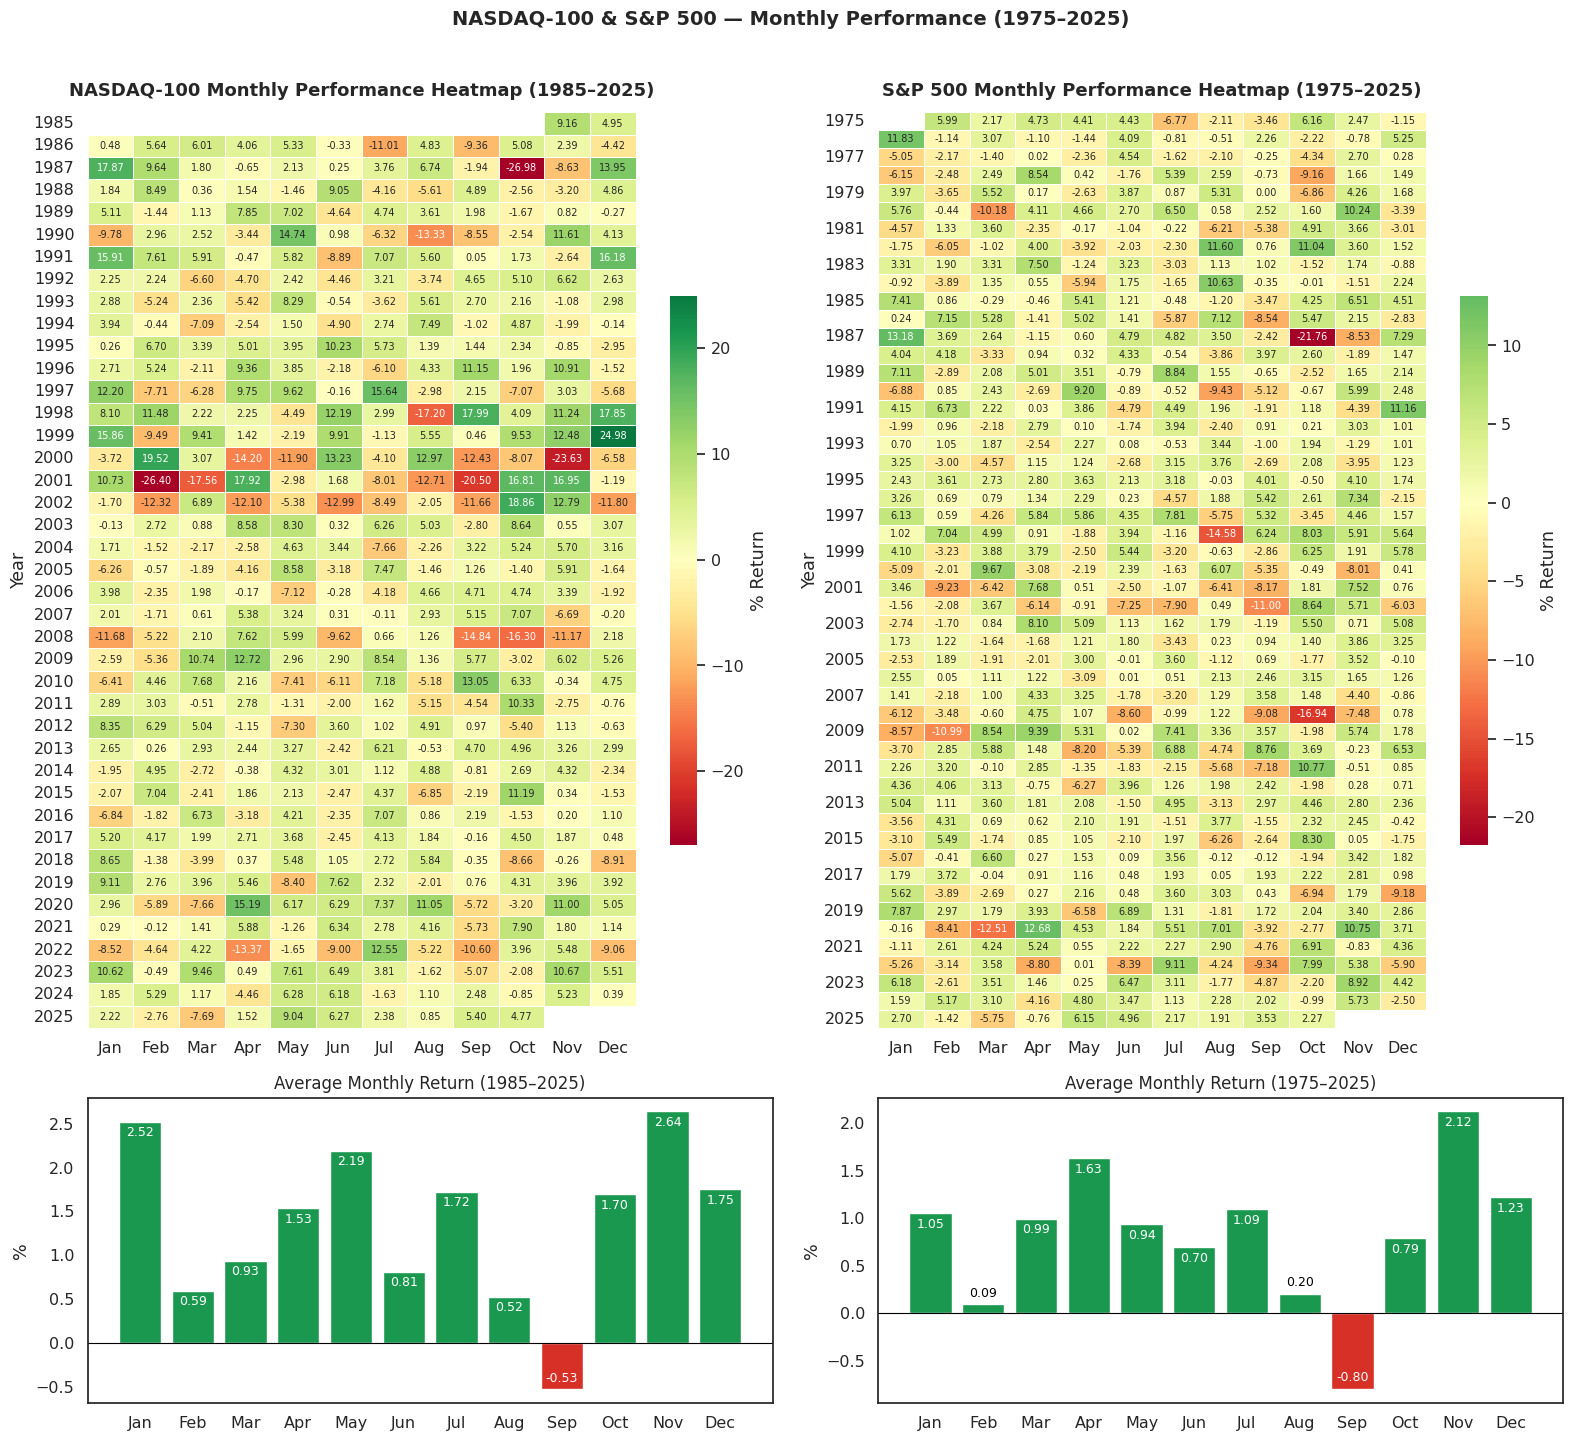



NASDAQ-100 Monthly Statistical Metrics Breakdown 1985-2025
| Month   |  Average Monthly Return (%)  |  Std Dev (%)  | Positive Rate (%)   |
|:--------|:----------------------------:|:-------------:|:--------------------|
| Jan     |             2.52             |     6.89      | 70.00% (28/40)      |
| Feb     |             0.59             |     7.52      | 50.00% (20/40)      |
| Mar     |             0.93             |     5.57      | 67.50% (27/40)      |
| Apr     |             1.53             |     6.84      | 60.00% (24/40)      |
| May     |             2.19             |      5.8      | 67.50% (27/40)      |
| Jun     |             0.81             |     6.11      | 52.50% (21/40)      |
| Jul     |             1.72             |     5.85      | 67.50% (27/40)      |
| Aug     |             0.52             |     6.27      | 60.00% (24/40)      |
| Sep     |            -0.53             |     7.45      | 55.00% (22/40)      |
| Oct     |             1.7              |     8

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from tabulate import tabulate

warnings.filterwarnings('ignore')

tickers = {'^NDX': 'NASDAQ-100', '^SPX': 'S&P 500'}
start_date = '1975-01-01'
end_date = '2025-11-01' #datetime.today().strftime('%Y-%m-%d') --> for "up to today"

# toggle to show numbers inside the heatmap boxes
show_values = True

data = yf.download(list(tickers.keys()), start=start_date, end=end_date, interval='1d')['Close']

monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change() * 100

sns.set_theme(style="white", font_scale=1.05)
months_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

GREEN_GAIN = '#1a9850'
RED_LOSS = '#d73027'

nasdaq_monthly_metrics = []
spx_monthly_metrics = []

start_year_overall = monthly_returns.index.min().year

fig, axes = plt.subplots(2, 2, figsize=(16, 15), gridspec_kw={'height_ratios':[3.75,1.25]})
fig.subplots_adjust(hspace=0.25)
plt.suptitle(f"NASDAQ-100 & S&P 500 — Monthly Performance ({start_year_overall}–{datetime.today().year})",
             fontsize=14, weight='bold', y=0.96)


for col, (symbol, name) in enumerate(tickers.items()):
    df = monthly_returns[symbol].dropna().to_frame('Return')
    df['Year'] = df.index.year
    df['Month'] = df.index.month_name().str.slice(stop=3)

    start_year_ticker = df.index.min().year

    pivot = df.pivot_table(index='Year', columns='Month', values='Return')
    pivot = pivot[months_order]

    ax = axes[0, col]
    sns.heatmap(
        pivot,
        ax=ax,
        cmap='RdYlGn',
        center=0,
        annot=show_values,
        fmt=".2f",
        annot_kws={'fontsize': 7},
        linewidths=0.4,
        cbar=True,
        cbar_kws={'shrink': 0.6, 'label': '% Return'}
    )

    ax.set_title(f"{name} Monthly Performance Heatmap ({start_year_ticker}–{datetime.today().year})", fontsize=13, weight='semibold', pad=12)
    ax.set_xlabel("")
    ax.set_ylabel("Year")

    monthly_avg = df.groupby('Month')['Return'].mean().reindex(months_order)
    ax2 = axes[1, col]

    bar_colors = [GREEN_GAIN if x >= 0 else RED_LOSS for x in monthly_avg]
    bars = ax2.bar(months_order, monthly_avg, color=bar_colors)

    ax2.axhline(0, color='black', lw=0.8)
    ax2.set_title(f"Average Monthly Return ({start_year_ticker}–{datetime.today().year})", fontsize=12)
    ax2.set_ylabel("%")
    ax2.set_xticklabels(months_order, rotation=0)

    MIN_BAR_HEIGHT = 0.4
    LABEL_PADDING = 0.05

    for bar in bars:
        height = bar.get_height()

        if abs(height) > MIN_BAR_HEIGHT:
            # large enough bar --> place number inside, use white text for contrast
            text_color = 'white'
            if height >= 0:
                label_y = height - LABEL_PADDING # place just below the top edge
                va_align = 'top'
            else:
                label_y = height + LABEL_PADDING # place just above the bottom edge
                va_align = 'bottom'
        else:
            # tiny bar --> place outside, use black text to prevent overlap with 0-axis line
            text_color = 'black'
            if height >= 0:
                label_y = height + LABEL_PADDING
                va_align = 'bottom'
            else:
                label_y = height - LABEL_PADDING
                va_align = 'top'

        ax2.text(bar.get_x() + bar.get_width()/2, label_y, f"{height:.2f}",
                 ha='center', va=va_align, fontsize=9, color=text_color)

    monthly_std = df.groupby('Month')['Return'].std().reindex(months_order).fillna(0)
    monthly_positive_months = df[df['Return'] > 0].groupby('Month')['Return'].count().reindex(months_order).fillna(0)
    monthly_total_months = df.groupby('Month')['Return'].count().reindex(months_order).fillna(0)

    monthly_summary_metrics_for_ticker = []
    for month in months_order:
        win_rate_val = (monthly_positive_months.loc[month] / monthly_total_months.loc[month]) * 100 if monthly_total_months.loc[month] > 0 else 0
        monthly_summary_metrics_for_ticker.append({
            'Month': month,
            'Average Monthly Return (%)': f"{monthly_avg.loc[month]:.2f}",
            'Std Dev (%)': f"{monthly_std.loc[month]:.2f}",
            'Positive Rate (%)': f"{win_rate_val:.2f}% ({int(monthly_positive_months.loc[month])}/{int(monthly_total_months.loc[month])})"
        })

    if name == 'NASDAQ-100':
        nasdaq_monthly_metrics = monthly_summary_metrics_for_ticker
    elif name == 'S&P 500':
        spx_monthly_metrics = monthly_summary_metrics_for_ticker

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- display monthly quantitative metrics for NASDAQ-100 ---
if nasdaq_monthly_metrics:
    nasdaq_start_year = monthly_returns['^NDX'].dropna().index.min().year
    print(f"\n\n{'='*80}")
    print(f"NASDAQ-100 Monthly Statistical Metrics Breakdown {nasdaq_start_year}-{datetime.today().year}")
    print(f"{'='*80}")

    headers_monthly = list(nasdaq_monthly_metrics[0].keys())
    table_data_monthly = [list(metric.values()) for metric in nasdaq_monthly_metrics]

    print(tabulate(table_data_monthly, headers=headers_monthly, tablefmt='pipe', colalign=('left', 'center', 'center', 'left')))

# --- display monthly quantitative metrics for S&P 500 ---
if spx_monthly_metrics:
    spx_start_year = monthly_returns['^SPX'].dropna().index.min().year
    print(f"\n\n{'='*80}")
    print(f"S&P 500 Monthly Statistical Metrics Breakdown {spx_start_year}-{datetime.today().year}")
    print(f"{'='*80}")

    headers_monthly = list(spx_monthly_metrics[0].keys())
    table_data_monthly = [list(metric.values()) for metric in spx_monthly_metrics]

    print(tabulate(table_data_monthly, headers=headers_monthly, tablefmt='pipe', colalign=('left', 'center', 'center', 'left')))

This heatmap tells us the **market behaviour** of S&P500 and Nasdaq100.

From the statistical results, we can observe:
- The "September Effect" is real that **September is the only month with a negative average return** for both indexes.
- We can expect both indexes have **higher chances to get a positive and greater return in November** (>70% & +2%) --> get a better sense of certainty in the uncertain market.

## **NASDAQ100 Market Behaviour**

In [5]:
import yfinance as yf
import pandas as pd
import datetime
import warnings

warnings.filterwarnings('ignore')
THRESHOLD = 0.05
START_DATE = '2005-01-01'
TICKERS = ['^NDX']

threshold_percentage = THRESHOLD * 100
print(f"""
==========================================================
IDENTIFICATION CONDITIONS
==========================================================

A correction is defined from a 200-day rolling PEAK to a later TROUGH.

• A 'peak' is the highest closing price within the latest 200 trading days
  (rolling 200-day high).
• A 'trough' is the lowest price after a peak has been formed, until
  a new 200-day peak appears.
• A correction is recorded only if the drop from peak to trough
  exceeds the threshold of {threshold_percentage}%.

==========================================================
""")

def find_corrections(ticker, start_date, threshold):
    """
    Identifies corrections using:
    - PEAK = rolling 200-day highest close
    - TROUGH = lowest point after peak until next peak
    """
    df = yf.download(ticker, start=start_date, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs('Close', axis=1, level=0)
        except KeyError:
            df = df.iloc[:, 0]
    elif 'Close' in df.columns:
        df = df['Close']

    if isinstance(df, pd.DataFrame) and not df.empty:
        df = df.iloc[:, 0]

    if df.empty:
        return pd.DataFrame()

    # compute rolling 200-day peak
    df = df.to_frame(name="Close")
    df['RollingPeak'] = df['Close'].rolling(200).max()

    corrections = []

    peak_price = None
    peak_date = None
    trough_price = None
    trough_date = None

    for current_date, row in df.iterrows():
        price = float(row['Close'])
        rolling_peak = row['RollingPeak']

        # ignore periods before we have a valid 200-day peak
        if pd.isna(rolling_peak):
            continue

        # when today's rolling peak equals today's close → a NEW 200-day peak is confirmed
        if price == rolling_peak:
            if peak_price is not None and trough_price is not None:
                drawdown = (trough_price - peak_price) / peak_price
                if drawdown < -threshold:
                    corrections.append({
                        'Year': trough_date.year,
                        'Ticker': ticker,
                        'Peak Date': peak_date.strftime('%Y-%m-%d'),
                        'Peak Price': peak_price,
                        'Trough Date': trough_date.strftime('%Y-%m-%d'),
                        'Trough Price': trough_price,
                        'Drop %': round(drawdown * 100, 2)
                    })

            # reset to new peak
            peak_price = price
            peak_date = current_date
            trough_price = price
            trough_date = current_date

        else:
            # still under the 200-day peak → track trough
            if trough_price is None or price < trough_price:
                trough_price = price
                trough_date = current_date

    # handle last unfinished cycle
    if peak_price is not None and trough_price is not None:
        drawdown = (trough_price - peak_price) / peak_price
        if drawdown < -threshold:
            corrections.append({
                'Year': trough_date.year,
                'Ticker': ticker,
                'Peak Date': peak_date.strftime('%Y-%m-%d'),
                'Peak Price': peak_price,
                'Trough Date': trough_date.strftime('%Y-%m-%d'),
                'Trough Price': trough_price,
                'Drop %': round(drawdown * 100, 2)
            })

    return pd.DataFrame(corrections)

all_corrections = pd.DataFrame()
for t in TICKERS:
    result = find_corrections(t, START_DATE, THRESHOLD)
    all_corrections = pd.concat([all_corrections, result])

if not all_corrections.empty:
    all_corrections = all_corrections.sort_values(by=['Ticker', 'Trough Date'])

# --- Drawdown Frequency Analysis ---
print("\n" + "="*30)
print("FREQUENCY OF DRAWDOWNS (Absolute Drop %)")
print("="*30)

if not all_corrections.empty:
    abs_drops = all_corrections['Drop %'].abs()
    bins = [5, 10, 15, 1000]
    labels = ['5% to <10%', '10% to <15%', '>=15%']

    all_corrections['Correction Magnitude:'] = pd.cut(
        abs_drops,
        bins=bins,
        labels=labels,
        right=False
    )

    for ticker in TICKERS:
        print(f"\n--- Drawdown Frequencies for {ticker} ---")
        ticker_corrections = all_corrections[all_corrections['Ticker'] == ticker]
        frequency = ticker_corrections['Correction Magnitude:'].value_counts().reindex(labels, fill_value=0)
        print(frequency.to_string())
else:
    print("No corrections found to categorize.")

print("\n" + "="*60)
print(f"Detailed List of Major Correction (> {THRESHOLD*100}%) per Year")
print("="*60)

current_year = datetime.date.today().year
years = sorted(list(range(2005, current_year + 1)))

for ticker in TICKERS:
    subset = all_corrections[all_corrections['Ticker'] == ticker]

    for year in years:
        year_events = subset[subset['Year'] == year]
        count = len(year_events)

        if count > 0:
            print(f"\n[Year {year}] - Found {count}:")
            for _, row in year_events.iterrows():
                print(f"   From {row['Peak Date']} (${row['Peak Price']:.2f}) "
                      f"to {row['Trough Date']} (${row['Trough Price']:.2f}): {row['Drop %']}%")
        else:
            print(f"\n[Year {year}] - Found 0")



IDENTIFICATION CONDITIONS

A correction is defined from a 200-day rolling PEAK to a later TROUGH.

• A 'peak' is the highest closing price within the latest 200 trading days
  (rolling 200-day high).  
• A 'trough' is the lowest price after a peak has been formed, until
  a new 200-day peak appears.
• A correction is recorded only if the drop from peak to trough
  exceeds the threshold of 5.0%.
  


FREQUENCY OF DRAWDOWNS (Absolute Drop %)

--- Drawdown Frequencies for ^NDX ---
Correction Magnitude:
5% to <10%     18
10% to <15%    11
>=15%           9

Detailed List of Major Correction (> 5.0%) per Year

[Year 2005] - Found 0

[Year 2006] - Found 1:
   From 2006-01-11 ($1758.24) to 2006-07-21 ($1451.88): -17.42%

[Year 2007] - Found 2:
   From 2007-02-22 ($1846.34) to 2007-03-05 ($1712.94): -7.23%
   From 2007-07-19 ($2052.99) to 2007-08-16 ($1846.09): -10.08%

[Year 2008] - Found 1:
   From 2007-10-31 ($2238.98) to 2008-11-20 ($1036.51): -53.71%

[Year 2009] - Found 1:
   From 2009-

**Result Interpretation:**

Based on the results, over the **past 20 years**, there is **a total of 18 corrections in the 5% to 10% range occurred**. This suggests that a minor correction of this size is a near-annual occurrence and **we can assume this to happen every year**.

When combining the **more substantial drawdown** categories, **a total of 20 occurrences** (11 in the 10%-15% range plus 9 in the >15% range) were recorded. With 20 occurrences over 20 years, we can conclude that **the Nasdaq 100 has historically experienced at least one correction greater than 10% on an average annual basis**.

Notably, the **year 2014** stands out as an anomaly with the **highest frequency of corrections in a single year**, recording four distinct drawdowns. Crucially, **none of these corrections exceeded the 10% threshold** - higher minor volatility but low systematic risk. This also suggests that there is **less likelihood the market will undergo another >5% decline after experiencing three corrections in a single year like 2025**, providing a sense of certainty from the quantitative aspect.

This findings could serve as a useful indicator for future reference, providing a sense of confidence for investors during market corrections (acknowledging that at least two corrections a year is historically proven common).

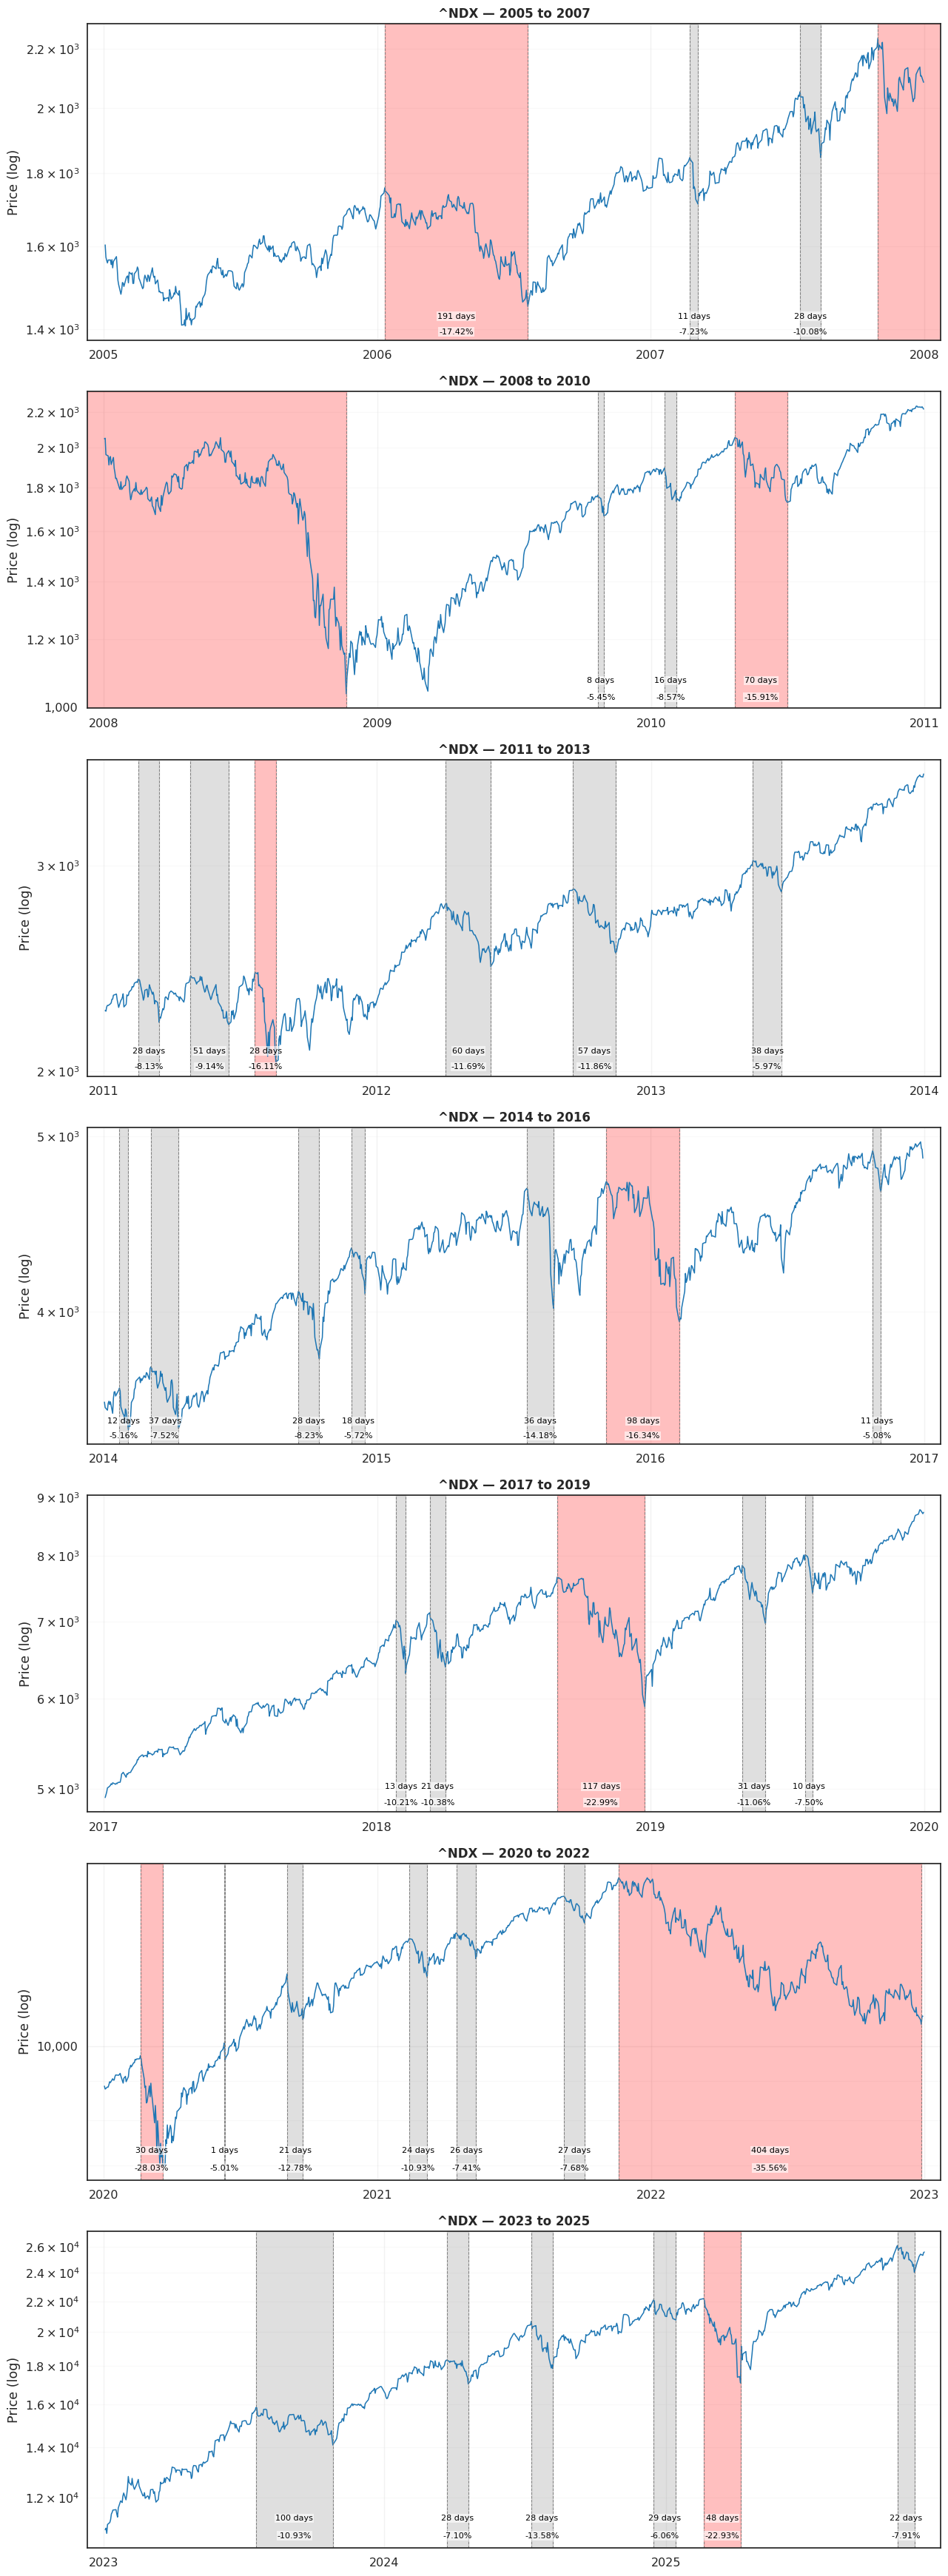

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import yfinance as yf
import pandas as pd
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

THRESHOLD = 0.05
START_DATE_CORRECTIONS = '2005-01-01'
TICKERS_FOR_CORRECTIONS = ['^NDX']

def find_corrections(ticker, start_date, threshold):
    """
    Identifies corrections using:
    - PEAK = rolling 200-day highest close
    - TROUGH = lowest point after peak until next peak
    """
    df = yf.download(ticker, start=start_date, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs('Close', axis=1, level=0)
        except KeyError:
            df = df.iloc[:, 0]
    elif 'Close' in df.columns:
        df = df['Close']

    if isinstance(df, pd.DataFrame) and not df.empty:
        df = df.iloc[:, 0]

    if df.empty:
        return pd.DataFrame()

    # compute rolling 200-day peak
    df = df.to_frame(name="Close")
    df['RollingPeak'] = df['Close'].rolling(200).max()

    corrections = []

    peak_price = None
    peak_date = None
    trough_price = None
    trough_date = None

    for current_date, row in df.iterrows():
        price = float(row['Close'])
        rolling_peak = row['RollingPeak']

        # ignore periods before we have a valid 200-day peak
        if pd.isna(rolling_peak):
            continue

        # when today's rolling peak equals today's close → a NEW 200-day peak is confirmed
        if price == rolling_peak:
            # finalize previous correction if threshold met
            if peak_price is not None and trough_price is not None:
                drawdown = (trough_price - peak_price) / peak_price
                if drawdown < -threshold:
                    corrections.append({
                        'Year': trough_date.year,
                        'Ticker': ticker,
                        'Peak Date': peak_date.strftime('%Y-%m-%d'),
                        'Peak Price': peak_price,
                        'Trough Date': trough_date.strftime('%Y-%m-%d'),
                        'Trough Price': trough_price,
                        'Drop %': round(drawdown * 100, 2)
                    })

            # reset to new peak
            peak_price = price
            peak_date = current_date
            trough_price = price
            trough_date = current_date

        else:
            # still under the 200-day peak → track trough
            if trough_price is None or price < trough_price:
                trough_price = price
                trough_date = current_date

    # handle last unfinished cycle
    if peak_price is not None and trough_price is not None:
        drawdown = (trough_price - peak_price) / peak_price
        if drawdown < -threshold:
            corrections.append({
                'Year': trough_date.year,
                'Ticker': ticker,
                'Peak Date': peak_date.strftime('%Y-%m-%d'),
                'Peak Price': peak_price,
                'Trough Date': trough_date.strftime('%Y-%m-%d'),
                'Trough Price': trough_price,
                'Drop %': round(drawdown * 100, 2)
            })

    return pd.DataFrame(corrections)

all_corrections = pd.DataFrame()
for t_corr in TICKERS_FOR_CORRECTIONS:
    result = find_corrections(t_corr, START_DATE_CORRECTIONS, THRESHOLD)
    all_corrections = pd.concat([all_corrections, result])

if not all_corrections.empty:
    all_corrections = all_corrections.sort_values(by=['Ticker', 'Trough Date'])


def plot_corrections_by_step(ticker, start_date, corrections_df, STEP_YEARS=3):
    df = yf.download(ticker, start=start_date, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs('Close', axis=1, level=0)
        except:
            df = df.iloc[:, 0]
    elif 'Close' in df.columns:
        df = df['Close']

    if isinstance(df, pd.DataFrame):
        df = df.iloc[:, 0]

    df = df.to_frame(name="Close")

    df.index = pd.to_datetime(df.index)

    corrections_df = corrections_df.copy()
    corrections_df["Peak Date"] = pd.to_datetime(corrections_df["Peak Date"])
    corrections_df["Trough Date"] = pd.to_datetime(corrections_df["Trough Date"])

    start_year = df.index[0].year
    end_year = df.index[-1].year
    last_data_date = df.index[-1]

    segment_edges = list(range(start_year, end_year + 1, STEP_YEARS))
    num_segments = len(segment_edges)

    fig, axes = plt.subplots(
        num_segments,
        1,
        figsize=(13, 5 * num_segments),
        sharex=False
    )

    if num_segments == 1:
        axes = [axes]

    for i, seg_start_year in enumerate(segment_edges):
        seg_end_year = seg_start_year + STEP_YEARS

        seg_start_date = pd.Timestamp(year=seg_start_year, month=1, day=1)
        seg_end_date = pd.Timestamp(year=seg_end_year, month=1, day=1)

        mask = (df.index >= seg_start_date) & (df.index < seg_end_date)
        df_sub = df[mask]

        if df_sub.empty:
            axes[i].set_visible(False)
            continue

        ax = axes[i]
        ax.plot(df_sub.index, df_sub["Close"], linewidth=1.1, color='#1f77b4')

        ax.set_yscale("log")

        ax.yaxis.set_major_formatter(mticker.FuncFormatter(
            lambda x, _:
             f"{int(x):,}" if x > 0 else ""
        ))

        ax.set_title(f"{ticker} — {seg_start_year} to {min(seg_end_year - 1, end_year)}", loc='center', fontsize=12, fontweight='bold')
        ax.set_ylabel("Price (log)")

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.grid(True, which='major', alpha=0.25)
        ax.grid(True, which='minor', alpha=0.1)

        # find corrections that OVERLAP with this segment.
        # Logic: (Correction Start < Segment End) AND (Correction End > Segment Start)
        overlap_mask = (
            (corrections_df["Peak Date"] < seg_end_date) &
            (corrections_df["Trough Date"] > seg_start_date)
        )
        seg_corr = corrections_df[overlap_mask]

        for _, row in seg_corr.iterrows():
            peak = row["Peak Date"]
            trough = row["Trough Date"]
            drop = abs(row["Drop %"])
            color = 'red' if drop >= 15 else 'grey'
            duration_days = (trough - peak).days

            ax.axvspan(peak, trough, color=color, alpha=0.25)

            if seg_start_date <= peak < seg_end_date:
                ax.axvline(peak, linestyle='--', color='grey', linewidth=0.7)
            if seg_start_date <= trough < seg_end_date:
                ax.axvline(trough, linestyle='--', color='grey', linewidth=0.7)

            # add duration label at the bottom center of the shaded area
            # only add if both peak and trough are within the current segment's view
            if peak >= seg_start_date and trough <= seg_end_date:
                text_x = peak + (trough - peak) / 2
                ymin, ymax = ax.get_ylim()

                # label for duration
                text_y_duration = ymin + (ymax - ymin) * 0.05
                ax.annotate(f'{duration_days} days', (text_x, text_y_duration),
                            textcoords="data",
                            ha='center', va='bottom', fontsize=8, color='black',
                            bbox=dict(boxstyle="square,pad=0.1", fc="white", alpha=0.6, ec='none'))

                # label for magnitude (percentage)
                text_y_magnitude = ymin + (ymax - ymin) * 0.03
                ax.annotate(f'-{drop:.2f}%', (text_x, text_y_magnitude),
                            textcoords="data",
                            ha='center', va='top', fontsize=8, color='black',
                            bbox=dict(boxstyle="square,pad=0.1", fc="white", alpha=0.6, ec='none'))

        # PREVENT FUTURE BLEEDING
        # Explicitly set X limits.
        # Left limit: Start of segment year.
        # Right limit: Jan 1st of next block OR Last actual data point (if this is the last block).

        view_min = seg_start_date

        if seg_end_date > last_data_date:
            view_max = last_data_date # cap at today
        else:
            view_max = seg_end_date   # cap at end of n-year block

        padding_days = (view_max - view_min).days * 0.02
        ax.set_xlim(view_min - pd.Timedelta(days=padding_days), view_max + pd.Timedelta(days=padding_days))

    plt.tight_layout()
    plt.show()

START_DATE = "2005-01-01"
TICKERS = ["^NDX"]
STEP_YEARS = 3
for t in TICKERS:
   subset = all_corrections[all_corrections["Ticker"] == t]
   plot_corrections_by_step(t, START_DATE, subset, STEP_YEARS=STEP_YEARS)

## **SPX & NDX Market Behaviour:** Percentage of Trading Days Within 5% Historical High

In [7]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

tickers = {'^SPX': 'S&P 500', '^NDX': 'NASDAQ 100'}
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

results = []

for ticker, name in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[['Close']].dropna().copy()

    # compute rolling all-time high
    df['AllTimeHigh'] = df['Close'].cummax()

    # compute % below all-time high
    df['PctBelowHigh'] = (df['AllTimeHigh'] - df['Close']) / df['AllTimeHigh']

    threshold = 0.05

    # determine whether within 5% of high
    df['Within5pct'] = df['PctBelowHigh'] <= threshold

    pct_within = df['Within5pct'].mean() * 100
    results.append([name, f"{pct_within:.2f}%"])

print(f"\n\n{tabulate(results, headers=["Index", "% of Days Within 5% of Previous High"], tablefmt="github")}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



| Index      | % of Days Within 5% of Previous High   |
|------------|----------------------------------------|
| S&P 500    | 51.62%                                 |
| NASDAQ 100 | 35.49%                                 |


**Result Interpretation:**

Since 1985, there is **51.6%** of trading days that **S&P500's price** is fluctuated **within the 5% range** of its **all-time-high level**. This indicates that has **remained at elevated levels** for more than half of all trading sessions for 40 years.

For **NASDAQ100,** although there is **only 35%** of trading days that it is fluctuated **within the 5% range** of its all-time-high, but this was primarily attributed to the “lost decade” following **the bursting of the dotcom bubble** (2000-2013) that makes prices consistently below its record-high during the bubble peak.

If we compute the percentage **since 2013** (after the recovery from dotcom bubble), the percentage is **67.9%** (with **S&P500 to be 71.7%**, according to the result below shows).

Meaning that, from the quantitative perspective, we should accept the fact that **US stocks are always traded at record-high levels**, discipline & systematic investing would help us to fight against FOMO.



In [8]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

tickers = {'^SPX': 'S&P 500', '^NDX': 'NASDAQ 100'}
start_date = '2013-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

results = []

for ticker, name in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[['Close']].dropna().copy()

    # compute rolling all-time high
    df['AllTimeHigh'] = df['Close'].cummax()

    # compute % below all-time high
    df['PctBelowHigh'] = (df['AllTimeHigh'] - df['Close']) / df['AllTimeHigh']

    threshold = 0.05

    # determine whether within 5% of high
    df['Within5pct'] = df['PctBelowHigh'] <= threshold

    pct_within = df['Within5pct'].mean() * 100
    results.append([name, f"{pct_within:.2f}%"])

print(f"\n\n{tabulate(results, headers=["Index", "% of Days Within 5% of Previous High"], tablefmt="github")}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



| Index      | % of Days Within 5% of Previous High   |
|------------|----------------------------------------|
| S&P 500    | 71.73%                                 |
| NASDAQ 100 | 67.92%                                 |


**↓ To show the repercussion of Dotcom bubble.**

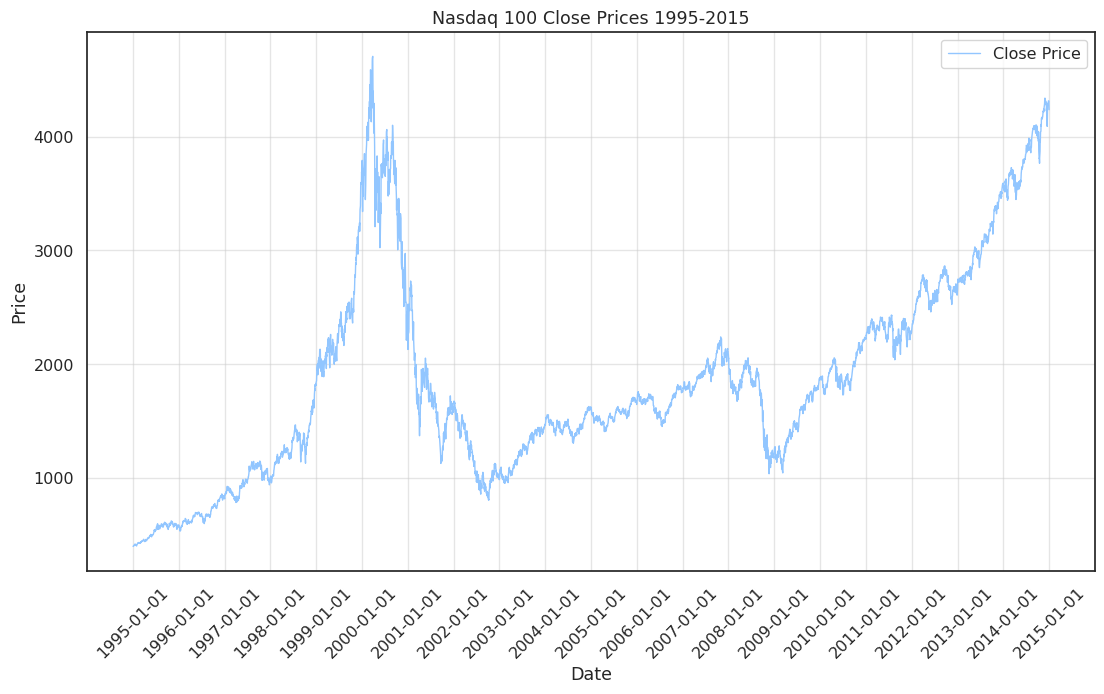

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

ticker = "^NDX"
df = yf.Ticker(ticker).history(start="1995-01-01", end="2015-01-01")

plt.figure(figsize=(13, 7))
plt.style.use("seaborn-v0_8-pastel")
plt.title(f"Nasdaq 100 Close Prices 1995-2015")
plt.grid(True, alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df["Close"], linewidth=1, label="Close Price")
years = pd.date_range(start="1995-01-01", end="2015-01-01", freq="YS", tz=df.index.tz)
plt.xticks(years, rotation=45)
plt.legend()
plt.show()


## **GOLD Quantitative Analysis - 15Y (August 2010 - August 2025)**

Price Visualization (with MA200), data retrieved from yahoo finance API

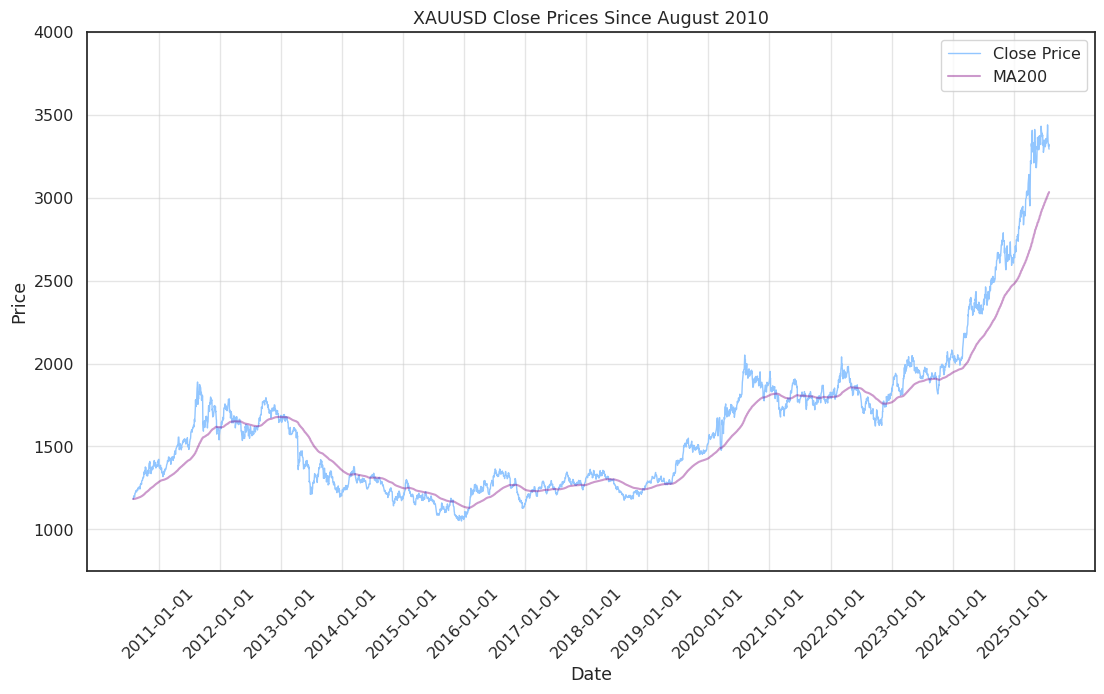

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

ticker = "GC=F"
df = yf.Ticker(ticker).history(start="2010-08-01", end="2025-08-01")

df['MA200'] = df['Close'].ewm(span=200, adjust=False).mean()

plt.figure(figsize=(13, 7))
plt.style.use("seaborn-v0_8-pastel")
plt.title(f"XAUUSD Close Prices Since August 2010")
plt.grid(True, alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df["Close"], linewidth=1.0, label="Close Price")
plt.plot(df["MA200"], linewidth=1.5, label="MA200", color='purple', alpha=0.4)
years = pd.date_range(start="2010-08-01", end="2025-08-01", freq="YS", tz=df.index.tz)
plt.xticks(years, rotation=45)
plt.ylim(750, 4000)
plt.legend()
plt.show()

yearly_data_list = []
for year in years:
    start_year = year
    end_year = year + pd.DateOffset(years=1) - pd.Timedelta(days=1)
    yearly_df = df[(df.index >= start_year) & (df.index <= end_year)].copy()
    below_count = (yearly_df['Close'] < yearly_df['MA200']).sum()
    total_days = len(yearly_df)
    percentage = (below_count / total_days) * 100 if total_days > 0 else 0
    yearly_data_list.append({'Year': start_year.year, '% Below MA200': f"{percentage:.2f}%"})

below_ema_df = pd.DataFrame(yearly_data_list)
transposed_df = below_ema_df.set_index('Year').T
styled_df = transposed_df.style.set_properties(**{'font-size': '10pt', 'border': '1px solid black'})

display(styled_df)

**File used below:**

Dataset from https://forexsb.com/historical-forex-data

XAUUSD_D1 --> Quantitative Analysis (From 21/8/2008 to 26/9/2025)

**↓ Extreme Check: Large Daily Range (≥ 90) and Large Daily Absolute Change (≥ 70)**

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

file_path = "/content/XAUUSD_D1.csv"
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

start_date = pd.to_datetime('01/08/2010', format='%d/%m/%Y')
end_date = pd.to_datetime('01/08/2025', format='%d/%m/%Y')
df = df.sort_values('Date')
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df['Range'] = df['High'] - df['Low']
df['Change'] = df['Close'] - df['Open']
df['abs_change'] = df['Change'].abs()
df['Return_%'] = df['Close'].pct_change() * 100  # daily return in %
df['Range_%'] = df['Range'] / df['Close'].shift(1) * 100
df['Change_%'] = df['Change'].abs() / df['Close'].shift(1) * 100

large_range_df = df[df['Range'] >= 90].sort_values('Range', ascending=False)[['Date', 'Range', 'Range_%']]
large_change_df = df[df['abs_change'] >= 70].sort_values('abs_change', ascending=False)[['Date', 'Change', 'Change_%']]

# Format the percentage columns to three decimal places for display
large_range_df['Range_%'] = large_range_df['Range_%'].map('{:.3f}'.format)
large_change_df['Change_%'] = large_change_df['Change_%'].map('{:.3f}'.format)

left = large_range_df.reset_index(drop=True)
right = large_change_df.reset_index(drop=True)

spacer = pd.DataFrame({"": [""] * max(len(left), len(right))})

combined_df = pd.concat([left, spacer, right], axis=1)

print(f"=== LARGE DAILY RANGE (≥ 90) and ABSOLUTE CHANGE (≥ 70) ===\n")
display(combined_df)

=== LARGE DAILY RANGE (≥ 90) and ABSOLUTE CHANGE (≥ 70) ===



Date    Range Range_%         Date   Change Change_%
0  2025-04-22  187.290   5.452   2013-04-15 -138.211    9.277
1  2013-04-15  160.923  10.801   2020-08-11 -119.103    5.873
2  2025-05-15  131.600   4.131   2024-11-25 -109.350    4.021
3  2011-09-26  128.059   7.765   2025-04-09  108.060    3.628
4  2025-04-09  127.720   4.288   2025-04-10  102.280    3.314
5  2020-08-11  126.900   6.257   2025-04-22  -98.671    2.873
6  2025-04-23  126.890   3.803   2025-04-16   98.230    3.021
7  2025-05-08  126.260   3.740   2011-08-24  -88.827    4.833
8  2011-09-23  126.214   7.246   2020-11-09  -87.747    4.480
9  2025-04-04  121.100   3.891   2025-04-21   86.659    2.588
10 2025-05-06  116.547   3.496   2025-05-05   85.990    2.648
11 2020-11-09  115.017   5.873   2011-09-23  -85.555    4.912
12 2024-11-25  114.890   4.224   2023-12-04  -84.110    3.971
13 2025-04-10  112.940   3.659   2012-02-29  -83.839    4.694
14 2011-08-24  112.234   6.106   2024-06-07  -83.260    3.503
15 2025-04-03  110.640   3.499   2024-11-06  -81.610    2.973
16 2020-03-16  109.570   7.035   2013-04-12  -79.646    5.099
17 2025-04-16  106.000   3.260   2020-08-19  -77.587    3.869
18 2012-02-29  104.646   5.859   2025-06-02   77.243    2.334
19 2024-06-07  100.967   4.248   2020-03-23   75.420    5.057
20 2023-12-04  100.940   4.766   2025-04-04  -74.647    2.398
21 2025-05-20   99.560   3.090   2025-08-01   74.050    2.252
22 2025-04-07   99.055   3.302   2013-06-20  -71.984    5.347
23 2025-04-25   97.900   2.923   2011-08-23  -71.166    3.728
24 2024-04-12   97.630   4.108          NaT      NaN      NaN
25 2024-11-06   97.310   3.544          NaT      NaN      NaN
26 2025-04-21   96.760   2.890          NaT      NaN      NaN
27 2025-05-05   96.610   2.975          NaT      NaN      NaN
28 2022-02-24   96.460   5.049          NaT      NaN      NaN
29 2024-08-05   94.491   3.871          NaT      NaN      NaN
30 2016-06-24   94.200   7.433          NaT      NaN      NaN
31 2021-08-08   93.960   5.331          NaT      NaN      NaN
32 2020-03-13   93.427   5.926          NaT      NaN      NaN
33 2025-05-16   90.770   2.804          NaT      NaN      NaN
34 2025-06-02   90.740   2.741          NaT      NaN      NaN

**↑ Results Interpretation & Insights:**

- For Range, 15/Top 30 comes from 2025 --> Inflated volatility in 2025 --> Despite this is due to the **base value** of gold **becomes larger**, we still perceive this year as an outlier as it significantly impacted the result.

- For Change, 16/23 is **NEGATIVE**, **BUT** among them, 7/8 positive changes were contributed solely by year 2025 which is the outlier --> Gold prices tend to undergo sharp drop than rise --> Must have precautions to address this in order to avoid from being margin call.

- It is worth noting that different datasets may yield significantly different results, as the cutoff periods of each datasets vary (some GMT+8, some GMT+0, etc.)

.

Calculating **abosolute numbers** rather than **percentage** is make sense and practical here, because usually the outcomes of gold trading is based on pips difference instead of percentage changes (percentage is more suitable for investment).

**↓ Frequency Check: Probabilities of RANGE and CHANGE within Thresholds**

In [12]:
range_thresholds = list(range(20, 145, 10))
change_thresholds = list(range(10, 135, 10))

range_prob = {
    f'> {thresh}': (df['Range'] > thresh).mean() * 100 for thresh in range_thresholds
}
change_prob = {
    f'> {thresh}': (df['abs_change'] > thresh).mean() * 100 for thresh in change_thresholds
}

range_prob_df = pd.DataFrame(range_prob.items(), columns=['Threshold', 'Probability (%)'])
change_prob_df = pd.DataFrame(change_prob.items(), columns=['Threshold', 'Probability (%)'])

range_prob_df['Probability (%)'] = range_prob_df['Probability (%)'].map('{:.3f}'.format)
change_prob_df['Probability (%)'] = change_prob_df['Probability (%)'].map('{:.3f}'.format)

range_prob_display = range_prob_df.copy()
change_prob_display = change_prob_df.copy()

range_prob_display.columns = ['Range Threshold', 'Range Probability (%)']
change_prob_display.columns = ['Change Threshold', 'Change Probability (%)']

max_len_prob = max(len(range_prob_display), len(change_prob_display))
spacer_prob = pd.DataFrame({"": [""] * max_len_prob})

combined_prob_df = pd.concat([
    range_prob_display.reset_index(drop=True),
    spacer_prob,
    change_prob_display.reset_index(drop=True)
], axis=1)

print(f"=== Frequency of RANGE and ABSOLUTE CHANGE within Thresholds ===\n")
display(combined_prob_df)

=== Frequency of RANGE and ABSOLUTE CHANGE within Thresholds ===



Range Threshold Range Probability (%)   Change Threshold  \
0             > 20                38.363               > 10   
1             > 30                17.510               > 20   
2             > 40                 8.487               > 30   
3             > 50                 4.372               > 40   
4             > 60                 2.529               > 50   
5             > 70                 1.650               > 60   
6             > 80                 1.222               > 70   
7             > 90                 0.750               > 80   
8            > 100                 0.450               > 90   
9            > 110                 0.343              > 100   
10           > 120                 0.214              > 110   
11           > 130                 0.064              > 120   
12           > 140                 0.043              > 130   

   Change Probability (%)  
0                  33.841  
1                  13.523  
2                   6.044  
3                   2.572  
4                   1.393  
5                   0.836  
6                   0.514  
7                   0.343  
8                   0.150  
9                   0.107  
10                  0.043  
11                  0.021  
12                  0.021

We can potentially derive trading strategies from here.
- Eg. What is the average next-day gain/loss followed by a significant decline (change >50) and whether the win rate is significant (eg. 80% of next day movement is positive).

**↓ Distribution Plot (Range & Absolute Change)**

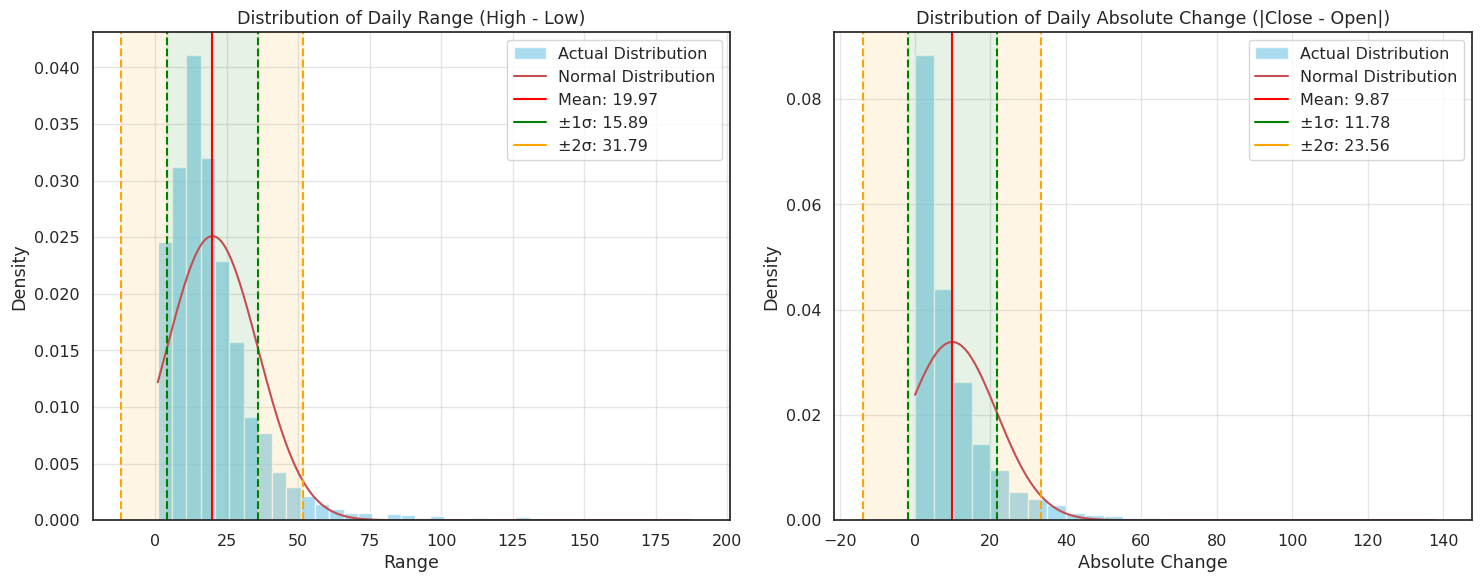

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Distribution Plot (Range) ---
range_bins = np.arange(df['Range'].min(), df['Range'].max() + 5, 5)
axes[0].hist(df['Range'], bins=range_bins, density=True, alpha=0.7, color='skyblue', label='Actual Distribution')

x_range = np.linspace(df['Range'].min(), df['Range'].max(), 1000)
mean_range = df['Range'].mean()
std_range = df['Range'].std()
y_range = stats.norm.pdf(x_range, mean_range, std_range)
axes[0].plot(x_range, y_range, 'r-', label='Normal Distribution')

# Shaded areas
axes[0].axvspan(mean_range - std_range, mean_range + std_range, color='green', alpha=0.1)
axes[0].axvspan(mean_range - 2*std_range, mean_range - std_range, color='orange', alpha=0.1)
axes[0].axvspan(mean_range + std_range, mean_range + 2*std_range, color='orange', alpha=0.1)

axes[0].axvline(mean_range, color='red', linestyle='-')
axes[0].axvline(mean_range + std_range, color='green', linestyle='--')
axes[0].axvline(mean_range - std_range, color='green', linestyle='--')
axes[0].axvline(mean_range + 2*std_range, color='orange', linestyle='--')
axes[0].axvline(mean_range - 2*std_range, color='orange', linestyle='--')

axes[0].plot([], [], color='red', label=f'Mean: {mean_range:.2f}')
axes[0].plot([], [], color='green', label=f'±1σ: {std_range:.2f}')
axes[0].plot([], [], color='orange', label=f'±2σ: {2*std_range:.2f}')

axes[0].set_title('Distribution of Daily Range (High - Low)')
axes[0].set_xlabel('Range')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.5)
axes[0].legend()

# --- Distribution Plot (Absolute Change) ---
change_bins = np.arange(df['abs_change'].min(), df['abs_change'].max() + 5, 5)
axes[1].hist(df['abs_change'], bins=change_bins, density=True, alpha=0.7, color='skyblue', label='Actual Distribution')

mean_change = df['abs_change'].mean()
std_change = df['abs_change'].std()

x_change = np.linspace(df['abs_change'].min(), df['abs_change'].max(), 1000)
y_change = stats.norm.pdf(x_change, mean_change, std_change)
axes[1].plot(x_change, y_change, 'r-', label='Normal Distribution')

axes[1].axvspan(mean_change - std_change, mean_change + std_change, color='green', alpha=0.1)
axes[1].axvspan(mean_change - 2*std_change, mean_change - std_change, color='orange', alpha=0.1)
axes[1].axvspan(mean_change + std_change, mean_change + 2*std_change, color='orange', alpha=0.1)

axes[1].axvline(mean_change, color='red', linestyle='-')
axes[1].axvline(mean_change + std_change, color='green', linestyle='--')
axes[1].axvline(mean_change - std_change, color='green', linestyle='--')
axes[1].axvline(mean_change + 2*std_change, color='orange', linestyle='--')
axes[1].axvline(mean_change - 2*std_change, color='orange', linestyle='--')

axes[1].plot([], [], color='red', label=f'Mean: {mean_change:.2f}')
axes[1].plot([], [], color='green', label=f'±1σ: {std_change:.2f}')
axes[1].plot([], [], color='orange', label=f'±2σ: {2*std_change:.2f}')

axes[1].set_title('Distribution of Daily Absolute Change (|Close - Open|)')
axes[1].set_xlabel('Absolute Change')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

**↑ Each bin represent a range of USD5.00** (therefore, for the range plot, the third bin, ranging from 10-15, is the median, while the mean is located on the fourth bin representing the range of 15-20).

**↓ Distribution Plot (Daily Return)**

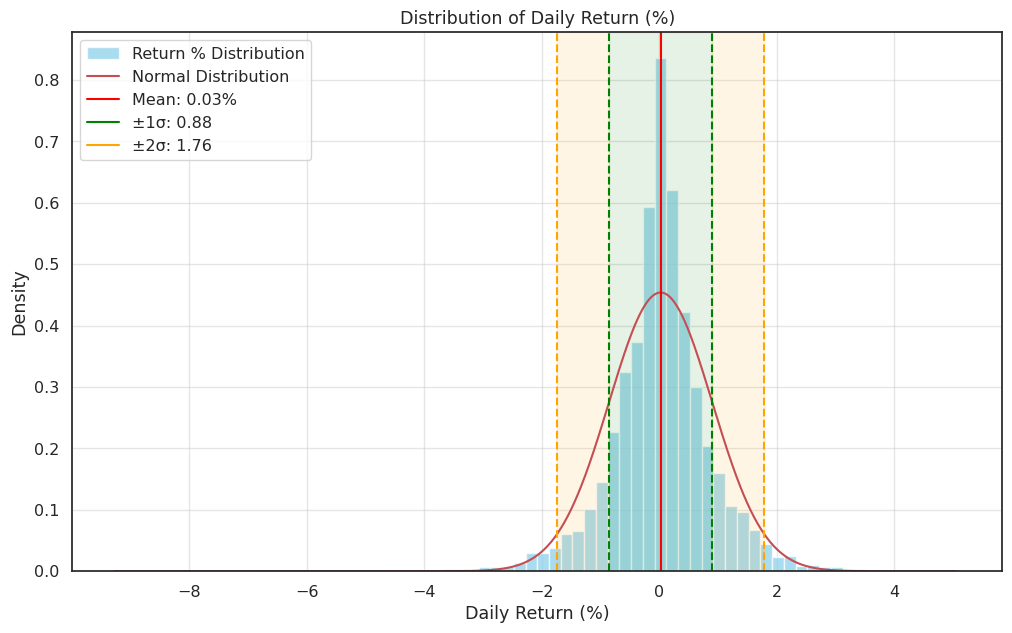

In [14]:
plt.figure(figsize=(12, 7))
return_bins = np.arange(df['Return_%'].min(), df['Return_%'].max() + 0.2, 0.2)
plt.hist(df['Return_%'].dropna(), bins=return_bins, density=True, alpha=0.7, color='skyblue', label='Return % Distribution')

mean = df['Return_%'].mean()
std = df['Return_%'].std()

x = np.linspace(df['Return_%'].min(), df['Return_%'].max(), 1000)
y = stats.norm.pdf(x, mean, std)
plt.plot(x, y, 'r-', label='Normal Distribution')

plt.axvspan(mean - std, mean + std, color='green', alpha=0.1) #, label='±1σ')
plt.axvspan(mean - 2*std, mean - std, color='orange', alpha=0.1) #, label='±2σ')
plt.axvspan(mean + std, mean + 2*std, color='orange', alpha=0.1)

plt.axvline(mean, color='red', linestyle='-')
plt.axvline(mean + std, color='green', linestyle='--')
plt.axvline(mean - std, color='green', linestyle='--')
plt.axvline(mean + 2*std, color='orange', linestyle='--')
plt.axvline(mean - 2*std, color='orange', linestyle='--')

plt.plot([], [], color='red', label=f'Mean: {mean:.2f}%')
plt.plot([], [], color='green', label=f'±1σ: {std:.2f}')
plt.plot([], [], color='orange', label=f'±2σ: {2*std:.2f}')

plt.title('Distribution of Daily Return (%)')
plt.xlabel('Daily Return (%)')
plt.ylabel('Density')
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()


**↑ Each bin represent a range of 0.2%** (therefore, [0.0, 0.2]% is the median).

.

**Result Interpretation:** Through observation, this is nearly a perfect normal distribution plot with long left tail --> This make sense, as we discovered earlier that the frequency of steep declines far exceeds the upward ones.